# _Venturia inaequalis AvrRvi5_ candidate validation

Jason Shiller has identified 10 _AvrRvi5_ candidates from comparative genomics and transcriptomics.
In this document I design a set of primers to RT-PCR amplify these candidates from _Venturia inaequalis_ MNH120, USR5 and the progeny resultant from a cross between them (Denoted 120.{9, 17, 19, 31, 37, 61, 65}).

## Required software

This was run in python 3.4.1 and the following packages were used in this analysis:

In [1]:
with open("requirements.txt", "r") as handle:
    print(handle.read())

bcbio-gff==0.6.2
biopython==1.65
Cython==0.23.2
decorator==4.0.2
ipykernel==4.0.3
ipython==4.0.0
ipython-genutils==0.1.0
ipywidgets==4.0.2
Jinja2==2.8
jsonschema==2.5.1
jupyter==1.0.0
jupyter-client==4.0.0
jupyter-console==4.0.2
jupyter-core==4.0.4
MarkupSafe==0.23
matplotlib==1.4.3
mistune==0.7.1
nbconvert==4.0.0
nbformat==4.0.0
nose==1.3.7
notebook==4.0.4
numpy==1.9.2
pandas==0.16.2
path.py==8.1.1
pexpect==3.3
pickleshare==0.5
primer3-py==0.4.1
ptyprocess==0.5
Pygments==2.0.2
pyparsing==2.0.3
python-dateutil==2.4.2
pytz==2015.4
pyzmq==14.7.0
qtconsole==4.0.1
scipy==0.16.0
simplegeneric==0.8.1
six==1.9.0
sympy==0.7.6.1
terminado==0.5
tornado==4.2.1
traitlets==4.0.0



To run this notebook for yourself create a new virtual environment in the prompt:

```{bash}
$ virtualenv env
$ source env/bin/activate
$ pip install numpy
$ pip install -r requirements
```

Then to run the notebook itself:

```{bash}
$ ipython notebook candidate_neighborhood.ipynb
```

Descriptor files for the output are written using the `%%writefile` cell magic after the file is created and before any descriptive analysis.

In [23]:
%matplotlib inline

In [1]:
import os
from os.path import join as pjoin
import shutil
import subprocess
import sys
from collections import defaultdict
from collections import OrderedDict
import json
import copy
import math

from Bio import AlignIO
from Bio import SeqIO
from Bio.SeqRecord import SeqRecord
from Bio.Seq import Seq
from Bio.SeqFeature import SeqFeature
from Bio.SeqFeature import CompoundLocation
from Bio.SeqFeature import FeatureLocation
from Bio.Blast.Applications import NcbiblastnCommandline
from Bio.Align.Applications import TCoffeeCommandline
from Bio.Alphabet import DNAAlphabet
from BCBio import GFF
import numpy as np
import pandas as pd
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib import patches
import matplotlib.gridspec as gridspec
from matplotlib.colors import LinearSegmentedColormap
import primer3
from primer3.bindings import designPrimers

In [2]:
#plt.style.use('ggplot')

In [5]:
%run lib/call_promer.py
%run lib/draw_wrappers.py
%run lib/gene_shapes.py
%run lib/intergenic_features.py
%run lib/links.py
%run lib/subfeatures.py
%run lib/subset_features.py

In [6]:
mpl.rcParams['text.usetex']=True
mpl.rcParams['text.latex.preamble'] = [
    r'\usepackage{siunitx}',
    r'\sisetup{detect-all}',
    r'\usepackage{helvet}',
    r'\usepackage{sansmath}',
    r'\sansmath',
    r'\usepackage{inconsolata}',
    ]

cdict = {
    'red':   ((0., 59/256, 59/256),
              (0.25, 120/256, 120/256),
              (0.5, 235/256, 235/236),
              (0.75, 225/256, 225/256),
              (1., 242/256, 242/256)),
    'green': ((0., 156/256, 156/256),
              (0.25, 183/256, 183/256),
              (0.5, 204/256, 204/256),
              (0.75, 175/256, 175/256),
              (1., 26/256, 26/256)),
    'blue':  ((0., 178/256, 178/256),
              (0.25, 197/256, 197/256),
              (0.5, 42/256, 42/256),
              (0.75, 0., 0.),
              (1., 0., 0.))
    }

zissou = LinearSegmentedColormap('Zissou', cdict)
plt.register_cmap(cmap=zissou)

cat_colours = [
    "#FF0000", "#00A08A", "#F2AD00",
    "#F98400", "#5BBCD6", "#046C9A",
    '#35274A', '#B40F20', "#D69C4E"
    ]

In [7]:
pd.set_option("display.max_colwidth", 800)
pd.set_option('display.max_rows', 1000)
THREADS = 3

First I altered the genome files slightly so that later on during BLAST searches I can tell which genome the scaffold belongs to.
I added the isolate name to the fasta descriptions with the following command.

```bash

sed -i.bak 's/>.*/&\ I31A/' data/I31A.gapfilled.final.fa && rm data/I31A.gapfilled.final.fa.bak
sed -i.bak 's/>.*/&\ I19A/' data/I19A.gapfilled.final.fa && rm data/I19A.gapfilled.final.fa.bak
sed -i.bak 's/>.*/&\ I65V/' data/I65V.gapfilled.final.fa && rm data/I65V.gapfilled.final.fa.bak
sed -i.bak 's/>.*/&\ MNH120/' data/MNH120.genome.masked.fasta && rm data/MNH120.genome.masked.fasta.bak
sed -i.bak 's/>.*/&\ I5V/' data/I5V.gapfilled.final.fa && rm data/I5V.gapfilled.final.fa.bak
sed -i.bak 's/>.*/&\ B04/' data/B04.genome.fa && rm data/B04.genome.fa.bak
sed -i.bak 's/>.*/&\ I37A/' data/I37A.gapfilled.final.fa && rm data/I37A.gapfilled.final.fa.bak
sed -i.bak 's/>.*/&\ I17V/' data/I17V.gapfilled.final.fa && rm data/I17V.gapfilled.final.fa.bak
sed -i.bak 's/>.*/&\ I61A/' data/I61A.gapfilled.final.fa && rm data/I61A.gapfilled.final.fa.bak
```

In [8]:
STEPS = {
    'data': 'data',
    'sequence_extraction': '01-extracted_candidates',
    'candidate_blast': '02-blasted_candidates_against_isolates',
    'extract_genes': '03-extracted_candidate_genes',
    'align_regions': '04-aligned_candidate_regions',
    'transcribed_regions': '05-found_transcribed_regions',
    'align_cds': '06-aligned_candidate_cds',
    'primer3': '07-primer3',
    'conserved_primers': '08-found_conserved_primers',
    'primer_blast': '09-primer_blast',
    'check_alternative': '10-checked_for_alternative_products',
    'primer_selection': '11-primer_selection',
    'primer_gff': '12-primer_gff',
    'drawing_genes': '13-drawing_gene_structures',
    'drawing_genes_transcripts': '14-drawing_genes_transcripts',
    'drawing_alignments': '15-drawing_alignments',
    'finding_kmers': '16-finding_kmers',
    }

for step, dir_ in STEPS.items():
    if not os.path.isdir(dir_):
        os.mkdir(dir_)



## Candidates
Jason identified 10 candidate _AvrRvi5_ genes.
Nine were discovered by comparative genomics, and 1 was discovered by comparative transcriptomics of 14 day old _Venturia inaequalis_ cultures in potato dextrose broth (PDB). atg10719 was the candidate identified by the transcriptomics method, it is expressed in MNH120 but not in Race 5.

Below is a summary dataframe of the candidates:

In [9]:
CANDIDATES = pd.read_csv(pjoin(STEPS['data'], "summary.DNA-seq.RNA-seq.csv"))
CANDIDATES

,method,gene,aa_mutation,length,gb_acc,blast_desc,organism,evalue,identity
0,DNA-seq,atg161,T184I,237,No hit,NaN,NaN,NaN,NaN
1,DNA-seq,atg162,T417A,459,WP_030543571.1,Hypothetical protein,Streptomyces albus,0.000000008,29
2,DNA-seq,atg4020,"P174PNAKPDAKPDAKPDAKP, V155L",185,XP_007283047.1,Snoal-like polyketide cyclase family protein,Colletotrichum gloeosporioides,3E-029,40.15
3,DNA-seq,atg12487,V388M,403,ADT70774.1,Cellobiose dehydrogenase,Dichomera saubinetii,7E-013,55.56
4,DNA-seq,atg140* (not original gene call) first 15 amino acids removed,D83N,232,No hit,NaN,NaN,NaN,NaN
5,DNA-seq,atg7465,V463I,626,EKG19035.1,Glycoside hydrolase family 1,Macrophomina phaesolina,0,75.36
6,DNA-seq,atg10724,"K178N,K239R",292,No hit,NaN,NaN,NaN,NaN
7,DNA-seq,atg10703,G102A,202,No hit,NaN,NaN,NaN,NaN
8,DNA-seq,atg4290,L423S,436,XP_007795436.1,putative chloroperoxidase-like protein [Eutypa lata UCREL1],Eutypa lata,1E-022,38
9,RNA-seq,atg10719,Not expressed in race 5,86,No hit,No hit,No hit,No hit,No hit


In [10]:
CANDIDATES.loc[4, "gene"] = "atg140"

In [11]:
# Subtract 1 because of 0 based indexing in python
TARGETS = {
    "atg161": [((184 - 1) * 3, 3)],
    "atg162": [((417 - 1) * 3, 3)],
    "atg4020": [((174 - 1) * 3, 3), ((155 - 1) * 3, 3)],
    "atg12487": [((388 - 1) * 3, 3)],
    "atg140": [((83 - 1) * 3, 3)],
    "atg7465": [((463 - 1) * 3, 3)],
    "atg10724": [((178 - 1) * 3, 3), ((239 - 1) * 3, 3)],
    "atg10703": [((102 - 1) * 3, 3)],
    "atg4290": [((427 - 1) * 3, 3)]
    }

TARGET_MUTATIONS = {
    "atg161": [('T', 'I')],
    "atg162": [('T', 'A')],
    "atg4020": [('P', 'PNAKPDAKPDAKPDAKP'), ('V', 'L')],
    "atg12487": [('V', 'M')],
    "atg140": [('D', 'N')],
    "atg7465": [('V', 'I')],
    "atg10724": [('K', 'N'), ('K', 'R')],
    "atg10703": [('G', 'A')],
    "atg4290": [('L', 'S')]
    }

In [12]:
GENOME_FILES = {
    'MNH120': {
        'fasta': pjoin(STEPS['data'], 'MNH120.genome.masked.fasta'),
        'gff': [
            pjoin(STEPS['data'], ('augustus.hints.GeneWithUTR'
                                  '.withNCBI_Fungi.gff3')),
            pjoin(STEPS['data'], 'MNH120.REPET_TEs.gff3'),
            pjoin(STEPS['data'], 'MNH120.REPET_SSRs.gff3'),
            ]
        },
    'B04': {
        'fasta': pjoin(STEPS['data'], 'B04.genome.fa'),
        'gff': [
            pjoin(STEPS['data'], 'B04.genes.gff3'),
            ]
        },
    'I5V': {
        'fasta': pjoin(STEPS['data'], 'I5V.gapfilled.final.fa'),
        'gff': [
            pjoin(STEPS['data'], 'I5V.PredictedPass.cleaned.gff3'),
            ]
        },
    'I9A': {
        'fasta': pjoin(STEPS['data'], 'I9A.gapfilled.final.fa'),
        'gff': [
            pjoin(STEPS['data'], 'I9A.PredictedPass.cleaned.gff3'),
            ]
        },
    'I17V': {
        'fasta': pjoin(STEPS['data'], 'I17V.gapfilled.final.fa'),
        'gff': [
            pjoin(STEPS['data'], 'I17V.PredictedPass.cleaned.gff3'),
            ]
        },
    'I19A': {
        'fasta': pjoin(STEPS['data'], 'I19A.gapfilled.final.fa'),
        'gff': [
            pjoin(STEPS['data'], 'I19A.PredictedPass.cleaned.gff3'),
            ]
        },
    'I31A': {
        'fasta': pjoin(STEPS['data'], 'I31A.gapfilled.final.fa'),
        'gff': [
            pjoin(STEPS['data'], 'I31A.PredictedPass.cleaned.gff3'),
            ],
        },
    'I37A': {
        'fasta': pjoin(STEPS['data'], 'I37A.gapfilled.final.fa'),
        'gff': [
            pjoin(STEPS['data'], 'I37A.PredictedPass.cleaned.gff3'),
            ],
        },
    'I61A': {
        'fasta': pjoin(STEPS['data'], 'I61A.gapfilled.final.fa'),
        'gff': [
            pjoin(STEPS['data'], 'I61A.PredictedPass.cleaned.gff3'),
            ],
        },
    'I65V': {
        'fasta': pjoin(STEPS['data'], 'I65V.gapfilled.final.fa'),
        'gff': [
            pjoin(STEPS['data'], 'I65V.PredictedPass.cleaned.gff3'),
            ],
        }
    }

In [13]:
GENOMES = dict()
for isolate, files in GENOME_FILES.items():
    # Import genome fasta as dict keyed by scaffold.
    GENOMES[isolate] = SeqIO.to_dict(
        SeqIO.parse(files['fasta'], format="fasta")
        )

    for gff in files['gff']:
        # Parse GFF annotations.
        genome_with_features = GFF.parse(
            gff,
            base_dict=GENOMES[isolate]
            )

        """ bcbio-gff codes exons, mRNA etc as subfeatures which is now
        depreciated in biopython, this code fixes that issue. """
        new_genome_with_features = list()
        for scaffold in genome_with_features:
            new_features = list()
            for feature in scaffold.features:
                gene_features = subfeatures(feature)
                new_features.extend(gene_features)
            scaffold.features = new_features
            new_genome_with_features.append(scaffold)

        """ Genome with features doesn't have scaffolds without any gff 
        features. Here I update the existing records in genome with the 
        new ones containing features. """
        GENOMES[isolate].update(SeqIO.to_dict(new_genome_with_features))

SCAF_TO_GENOME = dict()
for isolate, genome in GENOMES.items():
    for scaffold in genome:
        if scaffold in SCAF_TO_GENOME:
            raise KeyError(
                "Scaffold:" + scaffold + 
                "is present in more than 1 genome"
                )
        SCAF_TO_GENOME[scaffold] = isolate

In [14]:
def fix_atg140(genome):
    ids = ['atg140', 'atg140.t1', '1329']
    scaffold = 'scaffold_38'
    gene = SeqFeature(
        id='atg140',
        type='gene',
        location=FeatureLocation(24288, 25047, strand=-1)
        )
    mrna = SeqFeature(
        id='atg140.t1',
        type='mRNA',
        location=FeatureLocation(24288, 25047, strand=-1)
        )
    cds = SeqFeature(
        id='1329',
        type='CDS',
        location=CompoundLocation([
            FeatureLocation(24549, 25047, strand=-1),
            FeatureLocation(24288, 24484, strand=-1),
            ]),
        )
    new_features = [gene, mrna, cds]

    features = genome[scaffold].features
    for i in range(len(features)):
        if features[i].id in ids:
            #print(features[i])
            features[i] = new_features[ids.index(features[i].id)]
            #print(features[i])
    return features
GENOMES['MNH120']['scaffold_38'].features = fix_atg140(GENOMES['MNH120'])

In [15]:
BLASTDBS = dict()
for isolate, files in GENOME_FILES.items():
    command = [
        "makeblastdb",
        "-in", files['fasta'],
        "-input_type", "fasta",
        "-dbtype", "nucl",
        "-title", isolate,
        "-parse_seqids",
        "-taxid", "5025",
        "-out", pjoin(STEPS['data'], isolate)
        ]
    subps = subprocess.Popen(
        command,
        stdout=subprocess.PIPE,
        stderr=subprocess.PIPE
        )
    stdout, stderr = subps.communicate()
    BLASTDBS[isolate] = pjoin(STEPS['data'], isolate)

command = [
    "blastdb_aliastool",
    "-dblist", " ".join([v for k, v in BLASTDBS.items()]),
    "-dbtype", "nucl",
    "-title", 'combined',
    "-out", pjoin(STEPS['data'], 'combined')
    ]

subps = subprocess.Popen(
    command,
    stdout=subprocess.PIPE,
    stderr=subprocess.PIPE
    )
stdout, stderr = subps.communicate()
BLASTDBS['combined'] = pjoin(STEPS['data'], 'combined')

In [16]:
def roundup(x):
    """ Thanks to: <http://stackoverflow.com/questio\
    ns/8866046/python-round-up-integer-to-next-hundred>.
    """
    return x if x % 100 == 0 else x + 100 - x % 100

## Finding genomic regions containing these genes

First we need to know where these genes are in all of the isolates.
We know the names for MNH120 but not any of the other genomes.

### Step - `sequence_extraction`

In [18]:
candidate_set = set(CANDIDATES.gene)
atgs = list()
for scaffold_name, scaffold in GENOMES['MNH120'].items():
    for feature in scaffold.features:
        if feature.id in candidate_set:
            atg = {
                "scaffold": scaffold_name,
                "id": feature.id,
                "type": feature.type,
                "start": feature.location.start,
                "end": feature.location.end,
                "strand": feature.strand,
                "feature": feature
                }
            atgs.append(atg)

for atg in atgs:
    print((
        "The {type} {id} is found in scaffold "
        "{scaffold} from position {start} to {end} "
        "on strand {strand}"
        ).format(**atg))

The gene atg7465 is found in scaffold scaffold_893 from position 99033 to 100911 on strand -1
The gene atg4020 is found in scaffold scaffold_554 from position 5866 to 6421 on strand -1
The gene atg4290 is found in scaffold scaffold_447 from position 349816 to 351226 on strand 1
The gene atg161 is found in scaffold scaffold_48 from position 5456 to 6270 on strand -1
The gene atg162 is found in scaffold scaffold_48 from position 7067 to 8762 on strand -1
The gene atg12487 is found in scaffold scaffold_978 from position 243442 to 245087 on strand -1
The gene atg10703 is found in scaffold scaffold_996 from position 68793 to 69538 on strand 1
The gene atg10719 is found in scaffold scaffold_996 from position 112510 to 112881 on strand 1
The gene atg10724 is found in scaffold scaffold_996 from position 123743 to 124680 on strand 1
The gene atg140 is found in scaffold scaffold_38 from position 24288 to 25047 on strand -1


In [19]:
descriptor = """\
DNA sequences of all _AvrRvi5_ gene candidates identified \
by Jason Shiller in _Venturia inaequalis_ MNH120.

_AvrRvi5_ candidates are listed in \
'summary.DNA-seq.RNA-seq.csv' in the data folder.

Sequences were extracted from the genome \
'MNH120.genome.masked.fasta' using the gene sequences \
'augustus.hints.GeneWithUTR.withNCBI_Fungi.gff3'. \
These files are found in the 'data' folder.
"""

candidate_sequences = list()
for atg in atgs:
    sequence = atg["feature"].extract(
        GENOMES['MNH120'][atg["scaffold"]]
        )
    sequence.id = atg["id"]
    candidate_sequences.append(sequence)

filename = pjoin(
    STEPS['sequence_extraction'],
    "candidate_gene_sequences.fasta"
    )
SeqIO.write(
    sequences=candidate_sequences,
    handle=filename,
    format="fasta"
    )

filename = pjoin(
    STEPS['sequence_extraction'],
    "candidate_gene_sequences.fasta.txt"
    )
with open(filename, "w") as handle:
    handle.write(descriptor)
processed_atgs = list()
for atg in atgs:
    processed_atgs.append({
        'id': atg['id'],
        'scaffold': atg['scaffold'],
        'start': int(atg['start']),
        'end': int(atg['end']),
        'strand': atg['strand'],
        })
    
filename = pjoin(STEPS['sequence_extraction'], 'atgs.json')
with open(filename, 'w') as handle:
    json.dump(processed_atgs, handle, indent=4)

### Step - `candidate_blast`

In [20]:
output_columns = [
    "qseqid",
    "sseqid",
    "qstart",
    "qend",
    "sstart",
    "send",
    "evalue",
    "bitscore",
    "length",
    "pident",
    "sstrand",
    ]
descriptor = """\
BLASTN search of _Venturia inaequalis AvrRvi5_ candidates \
against a BLAST database constructed from the genome of isolates.

Depends on the fasta file containing candidates '{query}'.

It was constructed with the NCBI BLAST+ 2.2.29 build Jun  7 \
2014 15:55:48 program 'blastn' with the following command:

```bash
{command}
```

The table is tab ("\\t") separated with the following columns \
(in order):

- {columns}

Column names with the prefix 'q' refer to query sequence \
information and those with  's' refer to the matched sequence.

These messages came from running the code:

```
{stdout}
{stderr}
```
"""

blastn_result_files = list()

out = pjoin(STEPS['candidate_blast'], "blastn_candidates.csv")
blastn_cline = NcbiblastnCommandline(
    query=pjoin(
        STEPS['sequence_extraction'],
        "candidate_gene_sequences.fasta"
        ),
    db=BLASTDBS['combined'],
    out=out,
    outfmt='"6 ' + " ".join(output_columns) + '"',
    evalue=0.1,
    num_threads=THREADS
    )
stdout, stderr = blastn_cline()
    
with open(blastn_cline.out + ".txt", "w") as handle:
    handle.write(descriptor.format(
        query=blastn_cline.query,
        blast_db=blastn_cline.db,
        command=str(blastn_cline),
        stdout=stdout,
        stderr=stderr,
        columns="\n- ".join(output_columns)
        ))

In [21]:
blastn_results = pd.read_table(
    pjoin(STEPS['candidate_blast'], "blastn_candidates.csv"),
    sep="\t",
    header=None,
    names=output_columns
    )
isolates = list()
for i, row in blastn_results.iterrows():
    isolates.append(SCAF_TO_GENOME[row['sseqid']])
blastn_results.insert(1, 'isolate', pd.Series(isolates))
blastn_results.to_csv(
    pjoin(
        STEPS['candidate_blast'],
        "blastn_candidates_processed.csv"
        ),
    sep='\t',
    )
#blastn_results

In [23]:
blastn_results = pd.read_table(
    pjoin(
        STEPS['candidate_blast'],
        "blastn_candidates_processed.csv"
        ),
    sep='\t',
    index_col=0,
    )

best_blastn_results = list()
""" Here we get the highest scoring (by bitscore) match \
for each qseqid for each isolate and add that row to a \
list in a dictionary keyed by qseqid. """
for isolate, result in blastn_results.groupby(['isolate']):
    results = result.ix[
        result.groupby("qseqid")["bitscore"].idxmax()
        ]
    best_blastn_results.extend(
        [r for i, r in results.iterrows()]
        )

""" Convert the list of pandas Series objects back to a \
DataFrame. """
best_blastn_results = pd.DataFrame(best_blastn_results)

descriptor = """\
Summary of best blastn matches in each genome for _Venturia \
inaequalis AvrRvi5_ candidates.
Hits with the highest bitscore were considered to be the best hit.
Manual checks confirmed that these were the longest \
possible alignments with a percentage identity. \
This avoided short alignments with perfect % identity.

The table is tab ("\\t") separated.

Column names with the prefix 'q' refer to query sequence \
information and those with  's' refer to the matched sequence.
"""
out_file = pjoin(
    STEPS['candidate_blast'],
    "best_blastn_candidates.csv"
    )
best_blastn_results.to_csv(
    out_file,
    sep="\t",
    encoding="utf-8",
    index=False
    )
with open(out_file + ".txt", "w") as handle:
    handle.write(descriptor)
best_blastn_results

,qseqid,isolate,sseqid,qstart,qend,sstart,send,evalue,bitscore,length,pident,sstrand
61,atg10703,B04,B04S209,1,745,30462,31206,0.000000e+00,1376,745,100.00,plus
74,atg10719,B04,B04S209,1,371,82228,82603,5.000000e-137,490,380,90.53,plus
96,atg10724,B04,B04S209,1,937,93473,94409,0.000000e+00,1731,937,100.00,plus
170,atg12487,B04,B04S84,1,1645,159063,160707,0.000000e+00,3038,1645,100.00,plus
6,atg140,B04,B04S196,1,759,69605,70363,0.000000e+00,1397,759,99.87,plus
150,atg161,B04,B04S209,1,814,10000,10813,0.000000e+00,1504,814,100.00,plus
160,atg162,B04,B04S209,1,1695,7508,9202,0.000000e+00,3125,1695,99.94,plus
51,atg4020,B04,B04S181,1,548,112299,111752,0.000000e+00,1013,548,100.00,minus
115,atg4290,B04,B04S185,1,1406,87134,88539,0.000000e+00,2564,1406,99.57,plus
180,atg7465,B04,B04S209,1,1878,29113,27236,0.000000e+00,3446,1878,99.79,minus


### Step - `extract_genes`

In [24]:
template = """\
Probable gene orthologs of MNH120 {candidate} in other isolates.

These genes were identified by a BLASTN search of \
{candidate} against each genome and finding any \
GFF features that overlap with the highest scoring \
(by bitscore) alignment.

Probable orthologues:

{orthologues}
"""

descriptor = """\
Nucleotide sequences of putative {candidate} homolog CDS's in \
multiple isolates.

Positions to extract were based on the results of a BLASTn \
search against each isolate.
Any GFF feature that overlaps in the aligned area \
(even partially) were used to extract from.
These sequences are the putative CDS's from those \
matching features.

Sequence ids in the fasta are named as:

\t<isolate>-<scaffold>-<gene id>

_Venturia inaequalis_ isolates represented in this fasta are:

- {isolates}
"""

candidate_template = """\
- Isolate: {i} scaffold: {s}
{g}
"""

best_blastn_results = pd.read_table(
    pjoin(
        STEPS['candidate_blast'],
        "best_blastn_candidates.csv"
        ),
    sep="\t"
    )


candidate_genes = defaultdict(dict)
for i, row in best_blastn_results.iterrows():
    candidate = row.qseqid
    start = min([row.sstart, row.send])
    end = max([row.sstart, row.send])
    if row.sstart > row.send:
        strand = -1
    else:
        strand = 1
    isolate = row.isolate
    features = subset_features(
        record=GENOMES[isolate][row.sseqid],
        start=start,
        end=end
        )
    features = [f for f in features if \
                f.type.lower() == 'cds']
    best_features = sorted(
        features,
        key=lambda f: abs(f.location.end - f.location.start),
        reverse=True
        )

    candidate_genes[row.qseqid][isolate] = {
        'features': best_features,
        'scaffold': row.sseqid,
        'start': row.sstart,
        'end': row.send,
        }

extracted_cds = defaultdict(dict)
extracted_cds_files = dict()
for candidate, d in candidate_genes.items():
    orthologues = list()
    sequences = list()
    for isolate, row in d.items():
        scaffold = row['scaffold']
        features = row['features']
        start = row['start']
        end = row['end']
        strand = 1
        if end - start < 0:
            strand = -1

        orthologues.append(candidate_template.format(
                i=isolate,
                s=scaffold,
                g="".join([str(i) for i in features])
                ))

        if len(features) == 0:
            new_feature = FeatureLocation(start, end, strand)
            sequence = new_feature.extract(
                GENOMES[isolate][scaffold]
                )
            sequence.id = "{i}-{scaf}:{s}..{e}".format(
                i=isolate,
                scaf=scaffold,
                s=str(start),
                e=str(end)
                )
            sequence.id = sequence.id.replace(" ", "_")
            sequence.description = ""
            sequences.append(sequence)
            extracted_cds[candidate][isolate] = [{
                'id': sequence.id,
                'seq': str(sequence.seq),
                }]
        else:
            these_sequences = list()
            for feature in features:
                if feature.type == 'CDS':
                    sequence = feature.extract(
                        GENOMES[isolate][scaffold]
                        )
                    sequence.id = "{i}-{scaf}-{id_}".format(
                        i=isolate,
                        scaf=scaffold,
                        id_=feature.id
                        )
                    sequence.id = sequence.id.replace(" ", "_")
                    sequence.description = ""
                    sequences.append(sequence)
                    these_sequences.append({
                        'id': sequence.id,
                        'seq': str(sequence.seq),
                        })
            extracted_cds[candidate][isolate] = these_sequences

    filename = pjoin(
        STEPS['extract_genes'],
        "isolate_gene_names_" + candidate + ".txt"
        )
    with open(filename, 'w') as handle:
        handle.write(template.format(
            candidate=candidate,
            orthologues="".join(orthologues)
            ))
    filename = pjoin(
        STEPS['extract_genes'],
        candidate + "_nucleotide_cds.fasta"
        )
    extracted_cds_files[candidate] = filename
    SeqIO.write(
        sequences,
        filename,
        'fasta'
        )
filename = pjoin(STEPS['extract_genes'], 'extracted_cds.json')
with open(filename, 'w') as handle:
    json.dump(extracted_cds, handle)

filename = pjoin(STEPS['extract_genes'], 'extracted_cds_files.json')
with open(filename, 'w') as handle:
    json.dump(extracted_cds_files, handle)

In [25]:
best_blastn_results = pd.read_table(
    pjoin(
        STEPS['candidate_blast'],
        "best_blastn_candidates.csv"
        ),
    sep="\t"
    )

descriptor = """\
Nucleotide sequences of putative {candidate} homologs \
in multiple isolates.

Positions to extract were based on the results of a \
BLASTn search against each isolate.
These sequences are the best matching genomic regions \
± 200 bases for each candidate.

Sequence ids in the fasta are named as:

\t<isolate>-<scaffold>:<start>..<end>

_Venturia inaequalis_ isolates represented in this fasta are:

- {isolates}
"""

pm = 200
extracted_regions = defaultdict(dict)
extracted_regions_files = dict()
for candidate, table in best_blastn_results.groupby(['qseqid']):
    sequences = list()
    for i, row in table.iterrows():
        isolate = row.isolate
        sequence = GENOMES[isolate][row.sseqid]

        start = min([row.sstart, row.send]) - pm
        if start - pm < 0:
            start = 0
        end = max([row.sstart, row.send]) + pm
        if end + pm > len(GENOMES[isolate][row.sseqid]):
            end = len(GENOMES[isolate][row.sseqid])

        sequence = GENOMES[isolate][row.sseqid][start:end]
        if row.sstart > row.send:
            strand = -1
            sequence = sequence.reverse_complement()
        else:
            strand = 1
        sequence.id = "{i}-{scaf}:{s}..{e}".format(
            i=isolate,
            scaf=row.sseqid,
            s=str(start),
            e=str(end)
            )
        sequence.id = sequence.id.replace(" ", "_")
        sequence.description = ""
        sequences.append(sequence)
        extracted_regions[candidate][isolate] = {
            'id': sequence.id,
            'scaffold': row.sseqid,
            'seq': str(sequence.seq),
            'start': start,
            'end': end,
            'strand': strand,
            }

    filename = pjoin(
        STEPS['extract_genes'],
        candidate + "_nucleotide_region.fasta"
        )
    extracted_regions_files[candidate] = filename
    SeqIO.write(sequences, filename, "fasta")

    with open(filename + ".txt", "w") as handle:
        handle.write(descriptor.format(
            candidate=candidate,
            isolates="\n- ".join(table.isolate)
            ))

filename = pjoin(
    STEPS['extract_genes'],
    'extracted_regions.json'
    )
with open(filename, 'w') as handle:
    json.dump(extracted_regions, handle)

filename = pjoin(
    STEPS['extract_genes'],
    'extracted_regions_files.json'
    )
with open(filename, 'w') as handle:
    json.dump(extracted_regions_files, handle)

In [26]:
vcf = pd.read_table(
    'data/fb.all.annotated.24.2.15.vcf',
    skiprows=59
    )
vcf.rename(columns={'#CHROM': 'CHROM'}, inplace=True)

In [27]:
best_blastn_results = pd.read_table(
    pjoin(
        STEPS['candidate_blast'],
        "best_blastn_candidates.csv"
        ),
    sep="\t"
    )

candidate_genes = defaultdict(dict)
for i, row in best_blastn_results.iterrows():
    candidate = row.qseqid
    start = min([row.sstart, row.send])
    end = max([row.sstart, row.send])
    if row.sstart > row.send:
        strand = -1
    else:
        strand = 1
    isolate = row.isolate
    features = subset_features(
        record=GENOMES[isolate][row.sseqid],
        start=start,
        end=end
        )
    features = [f for f in features if \
                f.type.lower() == 'cds']
    best_features = sorted(
        features,
        key=lambda f: abs(f.location.end - f.location.start),
        reverse=True
        )

    candidate_genes[row.qseqid][isolate] = {
        'features': best_features,
        'scaffold': row.sseqid,
        'start': row.sstart,
        'end': row.send,
        }

targets_genomic = defaultdict(list)
def split_gtfield(fmt, cell):
    fmt = fmt.split(':')
    gt = cell.split(':')
    return dict(zip(fmt, gt))

matching_rows = list()
for candidate, isolates in candidate_genes.items():
    scaf_id = isolates["MNH120"]['scaffold']
    feature = isolates["MNH120"]['features'][0]
    if candidate not in TARGETS:
        continue
    target_ref = SeqRecord(id=scaf_id, seq='')
    start = feature.location.start
    end = feature.location.end
    for i, row in vcf.loc[
            (vcf.CHROM == scaf_id) & \
            (vcf.POS >= start) & \
            (vcf.POS <= end)\
            ].iterrows():
        info  = row['INFO'].split(';')
        info = dict([i.split('=') for i in info])
        if 'EFF' in info:
            if not info['EFF'].startswith('NON_SYNONYMOUS_CODING'):
                continue
        else:
            continue
        race1 = ['is_b04', 'is_9', 'is_19',
                 'is_31', 'is_37', 'is_61']
        race5 = ['is_5', 'is_17', 'is_65']
        r1_test = [
            split_gtfield(row['FORMAT'], row[c])['GT'] == '0'
            for c in race1
            ]
        r5_test = [
            split_gtfield(row['FORMAT'], row[c])['GT'] == '1'
            for c in race5
            ]
        if not all(r1_test):
            continue
        if not all(r5_test):
            continue
        
        matching_rows.append(row)
matching_rows = pd.DataFrame(matching_rows)
matching_rows[['CHROM', 'POS', 'REF', 'ALT', 'INFO']]

,CHROM,POS,REF,ALT,INFO
461321,scaffold_996,69098,G,C,AB=0;ABP=0;AC=3;AF=0.333333;AN=9;AO=117;CIGAR=1X;DP=446;DPB=446;DPRA=0.711246;EPP=5.25601;EPPR=3.0169;GTI=0;LEN=1;MEANALT=1;MQM=60;MQMR=60;NS=9;NUMALT=1;ODDS=219.304;PAIRED=1;PAIREDR=0.987842;PAO=0;PQA=0;PQR=0;PRO=0;QA=4177;QR=11755;RO=329;RPP=3.02886;RPPR=4.12574;RUN=1;SAF=49;SAP=9.71031;SAR=68;SRF=172;SRP=4.49535;SRR=157;TYPE=snp;technology.illumina=1;EFF=NON_SYNONYMOUS_CODING(MODERATE|MISSENSE|gGc/gCc|G102A||atg10703|||atg10703.t1|1|1)
6228,scaffold_48,5617,G,A,AB=0;ABP=0;AC=3;AF=0.333333;AN=9;AO=111;CIGAR=1X;DP=422;DPB=422;DPRA=0.713826;EPP=8.66395;EPPR=3.57586;GTI=0;LEN=1;MEANALT=1;MQM=60;MQMR=60;NS=9;NUMALT=1;ODDS=188.332;PAIRED=1;PAIREDR=0.996785;PAO=0;PQA=0;PQR=0;PRO=0;QA=3987;QR=10996;RO=311;RPP=3.18637;RPPR=3.18486;RUN=1;SAF=49;SAP=6.31642;SAR=62;SRF=160;SRP=3.57586;SRR=151;TYPE=snp;technology.illumina=1;EFF=NON_SYNONYMOUS_CODING(MODERATE|MISSENSE|aCt/aTt|T184I||atg161|||atg161.t1|3|1)
182162,scaffold_447,351186,TG,CC,AB=0;ABP=0;AC=3;AF=0.333333;AN=9;AO=63;CIGAR=2X;DP=356;DPB=358.5;DPRA=0.859005;EPP=66.7413;EPPR=15.6882;GTI=0;LEN=2;MEANALT=2;MQM=37.4921;MQMR=46.4798;NS=9;NUMALT=1;ODDS=6.00129;PAIRED=0.84127;PAIREDR=0.666667;PAO=0;PQA=0;PQR=81.5;PRO=2.5;QA=2026;QR=6530;RO=198;RPP=139.813;RPPR=398.92;RUN=1;SAF=10;SAP=66.7413;SAR=53;SRF=80;SRP=18.8467;SRR=118;TYPE=mnp;technology.illumina=1;EFF=NON_SYNONYMOUS_CODING(MODERATE||ttg/tCC|L423S||atg4290|||atg4290.t1||1)
461887,scaffold_996,124422,G,T,AB=0;ABP=0;AC=3;AF=0.333333;AN=9;AO=139;CIGAR=1X;DP=438;DPB=438;DPRA=0.929766;EPP=3.02592;EPPR=3.36616;GTI=0;LEN=1;MEANALT=1;MQM=60;MQMR=60;NS=9;NUMALT=1;ODDS=173.713;PAIRED=1;PAIREDR=0.993311;PAO=0;PQA=0;PQR=0;PRO=0;QA=5048;QR=10825;RO=299;RPP=8.64988;RPPR=10.9191;RUN=1;SAF=56;SAP=14.3988;SAR=83;SRF=128;SRP=16.4386;SRR=171;TYPE=snp;technology.illumina=1;EFF=NON_SYNONYMOUS_CODING(MODERATE|MISSENSE|aaG/aaT|K178N||atg10724|||atg10724.t1|2|1)
461888,scaffold_996,124604,A,G,AB=0;ABP=0;AC=3;AF=0.333333;AN=9;AO=127;CIGAR=1X;DP=477;DPB=477;DPRA=0.725714;EPP=9.18275;EPPR=36.9845;GTI=0;LEN=1;MEANALT=1;MQM=60;MQMR=60;NS=9;NUMALT=1;ODDS=234.942;PAIRED=1;PAIREDR=0.994286;PAO=0;PQA=0;PQR=0;PRO=0;QA=4544;QR=12668;RO=350;RPP=5.07918;RPPR=5.49198;RUN=1;SAF=57;SAP=5.8999;SAR=70;SRF=163;SRP=6.58392;SRR=187;TYPE=snp;technology.illumina=1;EFF=NON_SYNONYMOUS_CODING(MODERATE|MISSENSE|aAa/aGa|K239R||atg10724|||atg10724.t1|2|1)
5590,scaffold_38,24846,C,T,AB=0;ABP=0;AC=3;AF=0.333333;AN=9;AO=123;CIGAR=1X;DP=480;DPB=480;DPRA=0.723684;EPP=5.14646;EPPR=3.30835;GTI=0;LEN=1;MEANALT=1;MQM=60;MQMR=60;NS=9;NUMALT=1;ODDS=201.162;PAIRED=0.739837;PAIREDR=0.854342;PAO=0;PQA=0;PQR=0;PRO=0;QA=4403;QR=12894;RO=357;RPP=3.45166;RPPR=5.2061;RUN=1;SAF=66;SAP=4.44029;SAR=57;SRF=193;SRP=8.12573;SRR=164;TYPE=snp;technology.illumina=1;EFF=NON_SYNONYMOUS_CODING(MODERATE|MISSENSE|Gat/Aat|D83N||atg140|||atg140.t1|1|1|WARNING_TRANSCRIPT_NO_START_CODON)
531751,scaffold_978,243490,C,T,AB=0;ABP=0;AC=3;AF=0.333333;AN=9;AO=115;CIGAR=1X;DP=428;DPB=428;DPRA=0.734824;EPP=3.93554;EPPR=7.34631;GTI=0;LEN=1;MEANALT=1;MQM=60;MQMR=60;NS=9;NUMALT=1;ODDS=166.304;PAIRED=1;PAIREDR=0.996805;PAO=0;PQA=0;PQR=0;PRO=0;QA=3788;QR=10754;RO=313;RPP=3.18024;RPPR=11.5089;RUN=1;SAF=63;SAP=5.29507;SAR=52;SRF=150;SRP=4.18276;SRR=163;TYPE=snp;technology.illumina=1;EFF=NON_SYNONYMOUS_CODING(MODERATE|MISSENSE|Gtg/Atg|V388M||atg12487|||atg12487.t1|5|1)
6230,scaffold_48,7196,T,C,AB=0;ABP=0;AC=3;AF=0.333333;AN=9;AO=140;CIGAR=1X;DP=484;DPB=484;DPRA=0.822157;EPP=4.56135;EPPR=4.83991;GTI=0;LEN=1;MEANALT=1.33333;MQM=60;MQMR=60;NS=9;NUMALT=1;ODDS=234.303;PAIRED=1;PAIREDR=0.997085;PAO=0;PQA=0;PQR=0;PRO=0;QA=5032;QR=12215;RO=343;RPP=10.5174;RPPR=5.29573;RUN=1;SAF=56;SAP=15.1705;SAR=84;SRF=162;SRP=5.29573;SRR=181;TYPE=snp;technology.illumina=1;EFF=NON_SYNONYMOUS_CODING(MODERATE|MISSENSE|Acg/Gcg|T417A||atg162|||atg162.t1|7|1)
172651,scaffold_554,5887,T,C,AB=0;ABP=0;AC=3;AF=0.333333;AN=9;AO=77;CIGAR=1X;DP=355;DPB=355;DPRA=0.630297;EPP=20.6359;EPPR=3.08085;GTI=0;LEN=1;MEANALT

In [28]:
genomic_targets = defaultdict(list)
genomic_targets['atg161'].append({
    'candidate': 'atg161',
    'pos': 5617,
    'scaffold': 'scaffold_48',
    'mutation_aa': ('T', 'I'),
    'aa_pos': 184,
    'mutation_dna': ('C', 'T'),
    })
genomic_targets['atg12487'].append({
    'candidate': 'atg12487',
    'pos': 243490,
    'scaffold': 'scaffold_978',
    'mutation_aa': ('V', 'M'),
    'aa_pos': 388,
    'mutation_dna': ('G', 'A'),
    })
genomic_targets['atg161'].append({
    'candidate': 'atg162',
    'pos': 7196,
    'scaffold': 'scaffold_48',
    'mutation_aa': ('T', 'A'),
    'aa_pos': 417,
    'mutation_dna': ('A', 'G'),
    })
genomic_targets['atg140'].append({
    'candidate': 'atg140',
    'pos': 24846,
    'scaffold': 'scaffold_38',
    'mutation_aa': ('D', 'N'),
    'aa_pos': 83,
    'mutation_dna': ('G', 'A'),
    })
genomic_targets['atg10724'].append({
    'candidate': 'atg10724',
    'pos': 124422,
    'scaffold': 'scaffold_996',
    'mutation_aa': ('K', 'N'),
    'aa_pos': 187,
    'mutation_dna': ('G', 'T'),
    })
genomic_targets['atg10724'].append({
    'candidate': 'atg10724',
    'pos': 124604,
    'scaffold': 'scaffold_996',
    'mutation_aa': ('K', 'R'),
    'aa_pos': 239,
    'mutation_dna': ('A', 'G'),
    })
genomic_targets['atg7465'].append({
    'candidate': 'atg7465',
    'pos': 99473,
    'scaffold': 'scaffold_893',
    'mutation_aa': ('V', 'I'),
    'aa_pos': 463,
    'mutation_dna': ('GTT', 'ATC'),
    })
genomic_targets['atg10703'].append({
    'candidate': 'atg10703',
    'pos': 69098,
    'scaffold': 'scaffold_996',
    'mutation_aa': ('G', 'A'),
    'aa_pos': 102,
    'mutation_dna': ('G', 'C'),
    })
genomic_targets['atg4290'].append({
    'candidate': 'atg4290',
    'pos': 351186,
    'scaffold': 'scaffold_447',
    'mutation_aa': ('L', 'S'),
    'aa_pos': 423,
    'mutation_dna': ('TG', 'CC'),
    })
genomic_targets['atg4020'].append({
    'candidate': 'atg4020',
    'pos': 5887,
    'scaffold': 'scaffold_554',
    'mutation_aa': ('N', 'D'), # 179
    'aa_pos': 179,
    'mutation_dna': ('A', 'G'), 
    })
genomic_targets['atg4020'].append({
    'candidate': 'atg4020',
    'pos': 5899,
    'scaffold': 'scaffold_554',
    'mutation_aa': ('D', 'N'), # 175
    'aa_pos': 175,
    'mutation_dna': ('G', 'A'), 
    })
genomic_targets['atg4020'].append({
    'candidate': 'atg4020',
    'pos': 5959,
    'scaffold': 'scaffold_554',
    'mutation_aa': ('V', 'L'),
    'aa_pos': 155,
    'mutation_dna': ('G', 'T'),
    })

filename = pjoin(STEPS['extract_genes'], 'genomic_targets.json')
with open(filename, 'w') as handle:
    json.dump(genomic_targets, handle)

In [30]:
descriptor = """\
GFF formatted file containing the variant sites for \
_AvrRvi5_ candidate genes.
"""
filename = pjoin(STEPS['extract_genes'], 'genomic_targets.json')
with open(filename, 'r') as handle:
    genomic_targets = json.load(handle)

target_gff = list()

for candidate, variants in genomic_targets.items():
    for variant in variants:
        location = FeatureLocation(
            variant['pos'],
            variant['pos'] + len(variant['mutation_dna'][0])
            )
        mutation = (
            variant['mutation_aa'][0] +
            str(variant['aa_pos']) +
            variant['mutation_aa'][1]
            )
        id_ = candidate + "-" + mutation
        feature = SeqFeature(
            location=location,
            id=id_,
            type='variant',
            qualifiers={'ID': id_, }
            )
        GENOMES["MNH120"][
            variant['scaffold']].features.append(feature)
        target_ref = SeqRecord(seq='', id=variant['scaffold'])
        target_ref.features.append(feature)
        target_gff.append(target_ref)

filename = pjoin(STEPS['extract_genes'], 'target_variants.gff3')
with open(filename, "w") as out_handle:
    GFF.write(target_gff, out_handle)
    
with open(filename + '.txt', 'w') as out_handle:
    out_handle.write(descriptor)

### Step - `align_regions`

In [31]:
descriptor = """\
Alignment of putative _Venturia inaequalis_ MNH120 {candidate} \
homologs.

Depends on {multi_fasta}.

Alignments were constructed using T-Coffee Version_11.00.8cbe486 \
with the following command run from the project base directory:

```
{command}
```

Note that the preliminary newick tree generated ({dnd}.dnd) \
were automatically constructed by T-Coffee in the project \
base directory and were later moved into this folder.

Both a machine readable file {aln} and the easy-on-the-eye \
file {html}.score_html represent the same information.

Sequence ids are named as:

\t<isolate>-<scaffold>:<start>..<end>
"""

filename = pjoin(
    STEPS['extract_genes'],
    'extracted_regions_files.json'
    )
with open(filename, 'r') as handle:
    extracted_regions_files = json.load(handle)

aligned_regions_files = dict()
for candidate, multi_fasta in extracted_regions_files.items():
    filename = pjoin(
        STEPS['align_regions'],
        candidate + "_region_aligned.fasta"
        )
    tcoffee_cline = TCoffeeCommandline(
        infile="S" + multi_fasta,
        type="dna",
        outfile=filename,
        output="fasta_aln,score_html,score_ascii",
        mode="mcoffee"
        )
    aligned_regions_files[candidate] = filename
    stdout, stderr = tcoffee_cline()
    
    shutil.move(
        os.path.split(multi_fasta.split(".fa")[0])[1] + ".dnd",
        pjoin(
            STEPS['align_regions'],
            candidate + "_region_aligned.dnd"
            )
        )
    
    with open(filename + ".txt", "w") as handle:
        handle.write(descriptor.format(
            candidate=candidate,
            multi_fasta=multi_fasta,
            command=str(tcoffee_cline),
            dnd=os.path.split(
                multi_fasta.split(".fas")[0]
                )[1],
            aln=filename,
            html=filename
            ))
filename = pjoin(
    STEPS['align_regions'],
    'aligned_regions_files.json'
)
with open(filename, 'w') as handle:
    json.dump(aligned_regions_files, handle, indent=4)

The first thing to note here is that none of the alignments really show sufficient large concensus regions to use the same primer pairs for all isolates.

If you are still looking at this file within the project folder you can view the pretty-printed T-Coffee output here:

- [atg10703](07-align_candidates/atg10703_region_aligned.fasta.score_html)
- [atg10719](07-align_candidates/atg10719_region_aligned.fasta.score_html)
- [atg10724](07-align_candidates/atg10724_region_aligned.fasta.score_html)
- [atg12487](07-align_candidates/atg12487_region_aligned.fasta.score_html)
- [atg140](07-align_candidates/atg140_region_aligned.fasta.score_html)
- [atg161](07-align_candidates/atg161_region_aligned.fasta.score_html)
- [atg162](07-align_candidates/atg162_region_aligned.fasta.score_html)
- [atg4020](07-align_candidates/atg4020_region_aligned.fasta.score_html)
- [atg4290](07-align_candidates/atg4290_region_aligned.fasta.score_html)
- [atg7465](07-align_candidates/atg7465_region_aligned.fasta.score_html)

## Primer design

Now that we know that we'll probably need to design individual primers for each isolate I just need to pump out the primers in a brute force manner.
I'll be using the [Primer3](http://primer3.sourceforge.net/) command line tool.

First we'll need to find the areas with decent RNA-seq coverage.

To do this I'll be looking manually at the alignments in the [integrative genome browser](https://www.broadinstitute.org/igv/).
To keep this notebook clean I won't include any picture in here but they will be in the step 06 folder.

### Step - `transcribed_regions`

In [32]:
transcribed_regions = dict()
transcribed_regions["atg10719"] = {
    "MNH120": [(112442, 112641), (112696, 112739),
               (112798, 113071)],
    "I17V": [(233102, 233207), (233401, 233550)],
    "I19A": [(31485, 31616), (31675, 31719),
             (31772, 31904)],
    "I31A": [(23493, 23636), (23691, 23735),
             (23793, 23923)],
    "I37A": [(844545, 844696), (844761, 844800),
             (844854, 844991)],  # First two are poor coverage
    "I61A": [(213783, 213928), (213983, 214027),
             (214085, 214238)],
    "I65V": [(57432, 57582), (57648, 57680),
             (57739, 57892)]
    }
transcribed_regions["atg140"] = {
    "I31A": [(35310, 35594), (35882, 36037),
             (36089,36922)],
    "I19A": [(224407, 224981)],
    "I5V": [],
    "I65V": [(118379, 119261), (119415, 119765)],
    "I61A": [(314865, 316035), (316137, 316544)],
    "B04": [],
    "MNH120": [(23934, 24484), (24549, 25132)],  # Edge of scaffold
    "I37A": [(52607, 52708), (52855, 53393),
             (53459, 53553), (53647, 53784)],
    "I17V": [],
    }
transcribed_regions["atg161"] = {
    "I31A": [(33988, 34521), (34579, 34854),
             (34919, 35050)],
    "I19A": [(97746, 97853), (97459, 97608)],
    "I5V": [],
    "I65V": [(261055, 261282)],  # Very low coverage
    "I61A": [(33973, 34120), (34530, 34736)],
    "B04": [],
    "MNH120": [(5161, 5820), (5896, 6152),
               (6201, 6279)],
    "I37A": [(1066708, 1007286), (1007343, 1007615),
             (1007728, 1007815)],
    "I17V": [],
    }
transcribed_regions["atg162"] = {
    "I31A": [(32726, 36009), (36065, 36330),
             (36383, 36555), (36609, 36866),
             (37100, 37213)],
    "I19A": [(98806, 99122), (99178, 99443),
             (99497,99641), (100097, 100161),
             (100213, 100303), (100453, 100371),
             (100656, 100940)],
    "I5V": [],
    "I65V": [(258002, 258407), (258463, 258640),
             (258693, 258786), (258854, 259132), 
             (259186, 259358), (259410, 259676),
             (259731, 260085)],
    "I61A": [(35303, 35699), (35753, 36020),
             (36073, 36243), (36298, 36738),
             (36790, 36937), (37024, 37643)],
    "B04": [],
    "MNH120": [(6994, 7306), (7362, 7572),
               (7786, 7851), (7905, 8112),
               (8659, 8711)],
    "I37A": [(1008395, 1008773), (1008829, 1009094),
             (1009147, 1009317), (1009372, 1009516), 
             (1010282, 1010574)],
    "I17V": [],
    }
transcribed_regions["atg4020"] = {
    "I31A": [(46909, 48305)],
    "I19A": [(382059, 382383), (382503, 383156)],
    "I5V": [],
    "I65V": [(75005, 76268)],
    "I61A": [(11533, 12925)],
    "B04": [],
    "MNH120": [(5911, 6189), (6337, 6553)],
    "I37A": [(786678, 787124), (787310, 787896)],
    "I17V": [],
    }
transcribed_regions["atg4290"] = {
    "I31A": [(21, 727), (843, 1120), (1223, 1732)],
    "I19A": [(279292, 279543), (279641, 279911),
             (280034, 280237), (280371, 281008)],
    "I5V": [],
    "I65V": [(42404, 43321), (43380, 43628),
             (43762, 44057), (44106, 44632)],
    "I61A": [(34310, 35306), (35511, 36220)],
    "B04": [],
    "MNH120": [(349634, 350123), (350179, 351220)],
    "I37A": [(72594, 73529), (73333, 73576),
             (73765, 73899)],  # Edge of scaffold
    "I17V": [],
    }
transcribed_regions["atg7465"] = {
    "I31A": [(15686, 16152), (12205, 17328),
             (17414, 17618)],
    "I19A": [(78746, 79265), (79317, 80472),
             (80535, 80730), (80792, 80844)],
    "I5V": [],
    "I65V": [(294317, 264568), (264629, 294831),
             (294901, 296041), (296096, 296375),
             (296436, 297002)],
    "I61A": [(15070, 158841), (15894, 17032),
             (17109, 17309), (17368, 17621)],
    "B04": [],
    "MNH120": [(98834, 99049), (99109, 99315),
               (99363, 100523), (100569, 100968)],
    "I37A": [(988247, 988429), (988490, 988915),
             (988968, 990107), (990177, 990381),
             (990443, 990685)],
    "I17V": [],
    }
transcribed_regions["atg10703"] = {
    "I31A": [(20217,20769), (20833, 21398)],
    "I19A": [(74873, 57328), (75806, 76548)],
    "I5V": [()],
    "I65V": [(297813, 298282), (298378, 298507),
             (298647, 299209)],
    "I61A": [(168889, 169996), (170411, 171326)],
    "B04": [],
    "MNH120": [(68650, 69121), (69261, 69822)],
    "I37A": [(887801, 888414), (888633, 888742),
             (888867, 889550)],
    "I17V": [],
    }
transcribed_regions["atg10724"] = {
    "I31A": [(34150, 35057), (35111, 35217),
             (35382, 35721)],
    "I19A": [(19687, 20029), (20179, 20398),
             (20493, 21209)],
    "I5V": [],
    "I65V": [(68091, 69198), (69295, 69811)],
    "I61A": [(224378, 225537), (225664, 226153)],
    "B04": [],
    "MNH120": [(123185, 124867)],
    "I37A": [(83269, 833079), (833271, 833478),
             (833589, 834299)],
    "I17V": [],
    }
transcribed_regions["atg12487"] = {
    "I31A": [(24580, 25549), (25607, 25706),
             (25988, 26112), (26163, 26325),
             (26379, 27084)],
    "I19A": [(209418, 209989), (210043, 210205),
             (210257, 210381), (210661, 210763), 
             (210818, 210949), (210983, 211301),
             (211530, 211785)],
    "I5V": [],
    "I65V": [(200107, 200813), (200866, 201029),
             (201081, 201205), (201485, 201586),
             (201642, 202731)],
    "I61A": [(205823, 206527), (206584, 266743),
             (206799, 206922), (207199, 207301),
             (207360, 207851), (208050, 209204)],
    "B04": [],
    "MNH120": [(243248, 244207), (244262, 244339),
               (244699, 244759), (245115, 245671)],
    "I37A": [(264700, 265406), (265459, 265797), 
             (266077, 266176), (266234, 266366), 
             (266397, 266712), (266925, 267203)],
    "I17V": [],
    }

filename = pjoin(
    STEPS['transcribed_regions'],
    "transcribed_regions.json"
    )
with open(filename, 'w') as handle:
    json.dump(transcribed_regions, handle)

### Step - `align_cds`

In [33]:
descriptor = """\
Alignment of putative _Venturia inaequalis_ MNH120 {candidate} \
homolog CDS's.

Depends on {multi_fasta}.

Alignments were constructed using T-Coffee Version_11.00.8cbe486 \
with the following command run from the project base directory:

```
{command}
```

Note that the preliminary newick tree generated ({dnd}.dnd) were \
automatically constructed by T-Coffee in the project base \
directory and were later moved into this folder.

Both a machine readable file {aln} and the easy-on-the-eye \
file {html}.score_html represent \
the same information.

Sequence ids are named as:

\t<isolate>-<scaffold>-<gene id>
"""

filename = pjoin(STEPS['extract_genes'], 'extracted_cds_files.json')
with open(filename, 'r') as handle:
    extracted_cds_files = json.load(handle)

aligned_cds_files = dict()
for candidate, multi_fasta in extracted_cds_files.items():
    filename = pjoin(
        STEPS['align_cds'],
        candidate + "_cds_aligned.fasta"
        )
    tcoffee_cline = TCoffeeCommandline(
        infile="S" + multi_fasta,
        type="dna",
        outfile=filename,
        output="fasta_aln,score_html,score_ascii",
        mode="mcoffee"
        )
    aligned_cds_files[candidate] = filename
    stdout, stderr = tcoffee_cline()
    
    shutil.move(
        os.path.split(multi_fasta.split(".fa")[0])[1] + ".dnd",
        pjoin(STEPS['align_cds'], candidate + "_cds_aligned.dnd")
        )
    
    with open(filename + ".txt", "w") as handle:
        handle.write(descriptor.format(
            candidate=candidate,
            multi_fasta=multi_fasta,
            command=str(tcoffee_cline),
            dnd=os.path.split(multi_fasta.split(".fas")[0])[1],
            aln=filename,
            html=filename
            ))
    
filename = pjoin(STEPS['align_cds'], 'aligned_cds_files.json')
with open(filename, 'w') as handle:
    json.dump(aligned_cds_files, handle, indent=4)

The results of these alignments show more conserved regions than the original alignments (more than would be expected just by intron removal etc).
Probably what has happened is some non-CDS information is mixing up the prealignment tree and therefore the order of pairwise alignments.
I am comfortable that we have a near optimal alignment in this case.

If you are still looking at this file within the project folder you can view the pretty-printed T-Coffee output here:

- [atg10703](18-align_candidate_cds/atg10703_cds_aligned.fasta.score_html)
- [atg10719](18-align_candidate_cds/atg10719_cds_aligned.fasta.score_html)
- [atg10724](18-align_candidate_cds/atg10724_cds_aligned.fasta.score_html)
- [atg12487](18-align_candidate_cds/atg12487_cds_aligned.fasta.score_html)
- [atg140](18-align_candidate_cds/atg140_cds_aligned.fasta.score_html)
- [atg161](18-align_candidate_cds/atg161_cds_aligned.fasta.score_html)
- [atg162](18-align_candidate_cds/atg162_cds_aligned.fasta.score_html)
- [atg4020](18-align_candidate_cds/atg4020_cds_aligned.fasta.score_html)
- [atg4290](18-align_candidate_cds/atg4290_cds_aligned.fasta.score_html)
- [atg7465](18-align_candidate_cds/atg7465_cds_aligned.fasta.score_html)

### Step - `primer3`

In [34]:
size_ranges = {
    "atg161": [(400, 600)],
    "atg162": [(300, 500)],
    "atg4020": [(100, 300), (300, 400)],
    "atg12487": [(600, 800)],
    "atg140": [(500, 600), (600, 700),
               (700, 800), (800, 900)],
    "atg7465": [(800, 1000), (1000, 1200)],
    "atg10724": [(550, 800)],
    "atg10703": [(400, 600)],
    "atg4290": [(400, 800), (800, 1200)],
    "atg10719": [(150, 350)]
    }
descriptor = """\
Primer candidates as determined by Primer3 for the _AvrRvi5_ \
canididate {candidate}.

The version of primer 3 used was 2.3.6.

The command was run with the following Boulder (See \
<http://primer3.sourceforge.net/primer3_manual.htm#\
commandLineTags>) options:

```
{seq_args}
{global_args}
```

Note that these are in json format rather than boulder.
"""

max_levels = 2  # The max number of variants at a primer position.
template_isolate = 'MNH120'

filename = pjoin(STEPS['extract_genes'], 'extracted_cds.json')
with open(filename, 'r') as handle:
    extracted_cds = json.load(handle)

primer3_results = dict()
for candidate, isolates in extracted_cds.items():
    seq_args = {
        'SEQUENCE_ID': candidate,
        'SEQUENCE_TEMPLATE': str(
            isolates[template_isolate][0]['seq']
            ).upper(),
        'SEQUENCE_INCLUDED_REGION': [
            0,
            len(isolates[template_isolate][0]['seq'])
            ]
        }
    if candidate in TARGETS:
        seq_args["SEQUENCE_TARGET"] = TARGETS[candidate]
    global_args = {
        'PRIMER_PRODUCT_SIZE_RANGE': size_ranges[candidate],
        'PRIMER_NUM_RETURN':500,
        'PRIMER_EXPLAIN_FLAG': 0,
        'PRIMER_MIN_SIZE': 18,
        'PRIMER_OPT_SIZE': 22,
        'PRIMER_MAX_SIZE': 25,
        'PRIMER_MIN_TM': 58.0,
        'PRIMER_OPT_TM': 64.0,
        'PRIMER_MAX_TM': 68.0,
        'PRIMER_MIN_GC': 40.0,
        'PRIMER_MAX_GC': 60.0,
        'PRIMER_MAX_NS_ACCEPTED': 0,
        'PRIMER_MAX_SELF_ANY': 12,
        'PRIMER_MAX_SELF_END': 8,
        'PRIMER_PAIR_MAX_COMPL_ANY': 12,
        'PRIMER_PAIR_MAX_COMPL_END': 8,
        'PRIMER_MUST_MATCH_THREE_PRIME': "NNNSS"
        }
    if candidate == 'atg4020':
        del global_args['PRIMER_MUST_MATCH_THREE_PRIME']
    
    these_primer3_results = designPrimers(
        seq_args = seq_args,
        global_args = global_args
        )
    primer3_results[candidate] = these_primer3_results
    print(
        candidate + ":",
        these_primer3_results["PRIMER_INTERNAL_EXPLAIN"]
        )
    
    filename = pjoin(
        STEPS['primer3'],
        candidate + "_primer3_results.json"
        )
    with open(filename, "w") as handle:
        json.dump(these_primer3_results, handle, indent=4)
    
    with open(filename + '.txt', "w") as handle:
        handle.write(descriptor.format(
            candidate=candidate,
            seq_args=json.dumps(seq_args, indent=4),
            global_args=json.dumps(global_args, indent=4)
            ))

filename = pjoin(STEPS['primer3'], "all_primer3_results.json")
with open(filename, "w") as handle:
    json.dump(primer3_results, handle, indent=4)

atg10703: considered 1105, unacceptable product size 602, ok 503
atg161: considered 711, unacceptable product size 208, ok 503
atg4290: considered 1666, unacceptable product size 1164, ok 502
atg10724: considered 931, unacceptable product size 429, ok 502
atg140: considered 1046, unacceptable product size 543, ok 503
atg12487: considered 0, ok 0
atg162: considered 4450, unacceptable product size 3945, ok 505
atg10719: considered 1034, unacceptable product size 532, ok 502
atg4020: considered 1405, unacceptable product size 900, ok 505
atg7465: considered 3305, unacceptable product size 2802, ok 503


atg4020 is a tough one to find primers for from the CDS because one of the targets is right on the 3-prime end on MNH120.
For both atg4020 and atg12487 the target site is very near the 3-prime edge of the CDS.
I'll try again for these with the genomic sequences, more for atg12487 because 4020 has some decent matches.

In [42]:
descriptor = """\
Primer candidates as determined by Primer3 for the _AvrRvi5_ \
canididate {candidate}.
This search was based on genomic data rather than CDS \
data used in the other examples.

The version of primer 3 used was 2.3.6.

The command was run with the following Boulder (See \
<http://primer3.sourceforge.net/primer3_manual.htm#\
commandLineTags>) options:

```
{seq_args}
{global_args}
```

Note that these are in json format rather than boulder.
"""
filename = pjoin(STEPS['primer3'], "all_primer3_results.json")
with open(filename, "r") as handle:
    primer3_results = json.load(handle)

filename = pjoin(STEPS['extract_genes'], 'genomic_targets.json')
with open(filename, 'r') as handle:
    targets_genomic = json.load(handle)

filename = pjoin(STEPS['extract_genes'], 'extracted_regions.json')
with open(filename, 'r') as handle:
    extracted_regions = json.load(handle)

candidate = "atg12487"

atg_region = extracted_regions[candidate]['MNH120']
targets = list()
for target in targets_genomic[candidate]:
    targets.append((target['pos'], len(target['mutation_dna'][1])))

start = min(atg_region['start'], atg_region['end'])
targets = [(s - start, l) for s, l in targets]

seq_args = {
    'SEQUENCE_ID': candidate,
    'SEQUENCE_TEMPLATE': atg_region['seq'].upper(),
    'SEQUENCE_INCLUDED_REGION': [0, len(atg_region['seq'])],
    "SEQUENCE_TARGET": targets,
    'SEQUENCE_EXCLUDED_REGION': [
        (52, 52), (268, 50),
        (433, 289), (824, 55)
        ],  # exclude introns
    }

global_args = {
    'PRIMER_PRODUCT_SIZE_RANGE': [
        (800, 1000), (1000, 1200)
        ],
    'PRIMER_NUM_RETURN': 500,
    'PRIMER_EXPLAIN_FLAG': 0,
    'PRIMER_MIN_SIZE': 18,
    'PRIMER_OPT_SIZE': 22,
    'PRIMER_MAX_SIZE': 25,
    'PRIMER_MIN_TM': 58.0,
    'PRIMER_OPT_TM': 64.0,
    'PRIMER_MAX_TM': 68.0,
    'PRIMER_MIN_GC': 40.0,
    'PRIMER_MAX_GC': 60.0,
    'PRIMER_MAX_NS_ACCEPTED': 0,
    'PRIMER_MAX_SELF_ANY': 12,
    'PRIMER_MAX_SELF_END': 8,
    'PRIMER_PAIR_MAX_COMPL_ANY': 12,
    'PRIMER_PAIR_MAX_COMPL_END': 8,
    'PRIMER_MUST_MATCH_THREE_PRIME': "NNNSS"
    }

these_primer3_results = designPrimers(
    seq_args = seq_args,
    global_args = global_args
    )

primer3_results[
    candidate + "_genomic_with_target"
    ] = these_primer3_results
print(
    candidate + " with target:",
    these_primer3_results["PRIMER_INTERNAL_EXPLAIN"]
    )

filename = pjoin(
    STEPS['primer3'],
    candidate + "_primer3_results_genomic_with_target.json"
    )
with open(filename, "w") as handle:
    json.dump(these_primer3_results, handle, indent=4)

with open(filename + '.txt', "w") as handle:
    handle.write(descriptor.format(
        candidate=candidate,
        seq_args=json.dumps(seq_args, indent=4),
        global_args=json.dumps(global_args, indent=4)
        ))

filename = pjoin(STEPS['primer3'], "all_primer3_results.json")
with open(filename, "w") as handle:
    json.dump(primer3_results, handle, indent=4)

atg12487 with target: considered 4800, unacceptable product size 4297, ok 503


In [43]:
descriptor = """\
Primer candidates as determined by Primer3 for the _AvrRvi5_ \
canididate {candidate}.
This search was based on genomic data rather than CDS \
data used in the other examples.

The version of primer 3 used was 2.3.6.

The command was run with the following Boulder (See \
<http://primer3.sourceforge.net/primer3_manual.htm#\
commandLineTags>) options:

```
{seq_args}
{global_args}
```

Note that these are in json format rather than boulder.
"""
filename = pjoin(STEPS['primer3'], "all_primer3_results.json")
with open(filename, "r") as handle:
    primer3_results = json.load(handle)

filename = pjoin(STEPS['extract_genes'], 'genomic_targets.json')
with open(filename, 'r') as handle:
    targets_genomic = json.load(handle)

filename = pjoin(STEPS['extract_genes'], 'extracted_regions.json')
with open(filename, 'r') as handle:
    extracted_regions = json.load(handle)
    
candidate = "atg12487"
atg_region = extracted_regions[candidate]['MNH120']
targets = list()
for target in targets_genomic[candidate]:
    targets.append((target['pos'], len(target['mutation_dna'][1])))

start = min(atg_region['start'], atg_region['end'])
targets = [(s - start, l) for s, l in targets]

seq_args = {
    'SEQUENCE_ID': candidate,
    'SEQUENCE_TEMPLATE': atg_region['seq'].upper(),
    'SEQUENCE_INCLUDED_REGION': [0, len(atg_region['seq'])],
    "SEQUENCE_TARGET": targets,
    'SEQUENCE_EXCLUDED_REGION': [
        (52, 52), (268, 50),
        (433, 289), (824, 55)
        ],  # exclude introns
    }
global_args = {
    'PRIMER_PRODUCT_SIZE_RANGE': [
        (800, 1000), (1000, 1200)
        ],
    'PRIMER_NUM_RETURN': 500,
    'PRIMER_EXPLAIN_FLAG': 0,
    'PRIMER_MIN_SIZE': 18,
    'PRIMER_OPT_SIZE': 22,
    'PRIMER_MAX_SIZE': 25,
    'PRIMER_MIN_TM': 58.0,
    'PRIMER_OPT_TM': 64.0,
    'PRIMER_MAX_TM': 68.0,
    'PRIMER_MIN_GC': 40.0,
    'PRIMER_MAX_GC': 60.0,
    'PRIMER_MAX_NS_ACCEPTED': 0,
    'PRIMER_MAX_SELF_ANY': 12,
    'PRIMER_MAX_SELF_END': 8,
    'PRIMER_PAIR_MAX_COMPL_ANY': 12,
    'PRIMER_PAIR_MAX_COMPL_END': 8,
    'PRIMER_MUST_MATCH_THREE_PRIME': "NNNSS"
    }



these_primer3_results = designPrimers(
    seq_args = seq_args,
    global_args = global_args
    )

primer3_results[
    candidate + "_genomic_with_target"
    ] = these_primer3_results
print(
    candidate + " with target:",
    these_primer3_results["PRIMER_INTERNAL_EXPLAIN"]
    )

filename = pjoin(
    STEPS['primer3'],
    candidate + "_primer3_results_genomic_with_target.json"
    )
with open(filename, "w") as handle:
    json.dump(these_primer3_results, handle, indent=4)

with open(filename + '.txt', "w") as handle:
    handle.write(descriptor.format(
        candidate=candidate,
        seq_args=json.dumps(seq_args, indent=4),
        global_args=json.dumps(global_args, indent=4)
        ))

filename = pjoin(STEPS['primer3'], "all_primer3_results.json")
with open(filename, "w") as handle:
    json.dump(primer3_results, handle, indent=4)

atg12487 with target: considered 4800, unacceptable product size 4297, ok 503


In [44]:
descriptor = """\
Primer candidates as determined by Primer3 for the _AvrRvi5_ \
canididate {candidate}.
This search was based on genomic data rather than \
CDS data used in the other examples.

The version of primer 3 used was 2.3.6.

The command was run with the following Boulder (See \
<http://primer3.sourceforge.net/primer3_manual.htm#\
commandLineTags>) options:

```
{seq_args}
{global_args}
```

Note that these are in json format rather than boulder.
"""
filename = pjoin(STEPS['primer3'], "all_primer3_results.json")
with open(filename, "r") as handle:
    primer3_results = json.load(handle)
    
filename = pjoin(STEPS['extract_genes'], 'genomic_targets.json')
with open(filename, 'r') as handle:
    targets_genomic = json.load(handle)

filename = pjoin(STEPS['extract_genes'], 'extracted_regions.json')
with open(filename, 'r') as handle:
    extracted_regions = json.load(handle)
    
candidate = "atg4020"
atg_region = extracted_regions[candidate]['MNH120']
targets = list()
for target in targets_genomic[candidate]:
    targets.append((target['pos'], len(target['mutation_dna'][1])))

start = min(atg_region['start'], atg_region['end'])
targets = [(s - start, l) for s, l in targets]

seq_args = {
    'SEQUENCE_ID': candidate,
    'SEQUENCE_TEMPLATE': atg_region['seq'].upper(),
    'SEQUENCE_INCLUDED_REGION': [
        0, len(atg_region['seq']) - 130
        ],
    "SEQUENCE_TARGET": targets
    }

global_args = {
    'PRIMER_NUM_RETURN':2000,
    'PRIMER_PRODUCT_SIZE_RANGE': [
        (100, 300), (400, 500)
        ],
    'PRIMER_EXPLAIN_FLAG': 0,
    'PRIMER_MIN_SIZE': 18,
    'PRIMER_OPT_SIZE': 22,
    'PRIMER_MAX_SIZE': 25,
    'PRIMER_MIN_TM': 50.0,
    'PRIMER_OPT_TM': 64.0,
    'PRIMER_MAX_TM': 68.0,
    'PRIMER_MIN_GC': 40.0,
    'PRIMER_MAX_GC': 60.0,
    'PRIMER_MAX_NS_ACCEPTED': 0,
    'PRIMER_MAX_SELF_ANY': 12,
    'PRIMER_MAX_SELF_END': 8,
    'PRIMER_PAIR_MAX_COMPL_ANY': 12,
    'PRIMER_PAIR_MAX_COMPL_END': 8
    }

these_primer3_results = designPrimers(
    seq_args = seq_args,
    global_args = global_args
    )
primer3_results[
    candidate + "_genomic_with_target"
    ] = these_primer3_results

print(
    candidate + " with target:",
    these_primer3_results["PRIMER_INTERNAL_EXPLAIN"]
    )

filename = pjoin(
    STEPS['primer3'],
    candidate + "_primer3_results_genomic_with_target.json"
    )
with open(filename, "w") as handle:
    json.dump(these_primer3_results, handle, indent=4)

with open(filename + '.txt', "w") as handle:
    handle.write(descriptor.format(
        candidate=candidate,
        seq_args=json.dumps(seq_args, indent=4),
        global_args=json.dumps(global_args, indent=4)
        ))

filename = pjoin(STEPS['primer3'], "all_primer3_results.json")
with open(filename, "w") as handle:
    json.dump(primer3_results, handle, indent=4)

atg4020 with target: considered 14468, unacceptable product size 12458, ok 2010


The gene atg4290 has some bad gene calls in the other isolates/progeny. 
Some exons are split into separate genes etc.
I will look at taking some primers from the genomic region here too.

In [45]:
descriptor = """\
Primer candidates as determined by Primer3 for the \
_AvrRvi5_ canididate {candidate}.
This search was based on genomic data rather \
than CDS data used in the other examples.

The version of primer 3 used was 2.3.6.

The command was run with the following Boulder (See \
<http://primer3.sourceforge.net/primer3_manual.htm\
#commandLineTags>) options:

```
{seq_args}
{global_args}
```

Note that these are in json format rather than boulder.
"""
filename = pjoin(STEPS['primer3'], "all_primer3_results.json")
with open(filename, "r") as handle:
    primer3_results = json.load(handle)

filename = pjoin(STEPS['extract_genes'], 'genomic_targets.json')
with open(filename, 'r') as handle:
    targets_genomic = json.load(handle)

filename = pjoin(STEPS['extract_genes'], 'extracted_regions.json')
with open(filename, 'r') as handle:
    extracted_regions = json.load(handle)
    
candidate = "atg4290"
atg_region = extracted_regions[candidate]['MNH120']
targets = list()
for target in targets_genomic[candidate]:
    targets.append((target['pos'], len(target['mutation_dna'][1])))

start = min(atg_region['start'], atg_region['end'])
targets = [(s - start, l) for s, l in targets]

seq_args = {
    'SEQUENCE_ID': candidate,
    'SEQUENCE_TEMPLATE': atg_region['seq'].upper(),
    'SEQUENCE_INCLUDED_REGION': [0, len(atg_region['seq'])],
    "SEQUENCE_TARGET": targets,
    'SEQUENCE_EXCLUDED_REGION': [(459, 561 - 459)]
    }
global_args = {
    'PRIMER_NUM_RETURN': 500,
    'PRIMER_PRODUCT_SIZE_RANGE': [
        (1100, 1300),
        (900, 1100),
        (700, 900),
        (500, 700)
        ],
    'PRIMER_EXPLAIN_FLAG': 0,
    'PRIMER_MIN_SIZE': 18,
    'PRIMER_OPT_SIZE': 22,
    'PRIMER_MAX_SIZE': 25,
    'PRIMER_MIN_TM': 58.0,
    'PRIMER_OPT_TM': 64.0,
    'PRIMER_MAX_TM': 68.0,
    'PRIMER_MIN_GC': 40.0,
    'PRIMER_MAX_GC': 60.0,
    'PRIMER_MAX_NS_ACCEPTED': 0,
    'PRIMER_MAX_SELF_ANY': 12,
    'PRIMER_MAX_SELF_END': 8,
    'PRIMER_PAIR_MAX_COMPL_ANY': 12,
    'PRIMER_PAIR_MAX_COMPL_END': 8,
    'PRIMER_MUST_MATCH_THREE_PRIME': "NNNSS"
    }

these_primer3_results = designPrimers(
    seq_args = seq_args,
    global_args = global_args
    )
primer3_results[candidate + "_genomic"] = these_primer3_results
print(
    candidate + ":",
    these_primer3_results["PRIMER_INTERNAL_EXPLAIN"]
    )

filename = pjoin(
    STEPS['primer3'],
    candidate + "_primer3_results_genomic.json"
    )
with open(filename, "w") as handle:
    json.dump(these_primer3_results, handle, indent=4)

with open(filename + '.txt', "w") as handle:
    handle.write(descriptor.format(
        candidate=candidate,
        seq_args=json.dumps(seq_args, indent=4),
        global_args=json.dumps(global_args, indent=4)
        ))

filename = pjoin(STEPS['primer3'], "all_primer3_results.json")
with open(filename, "w") as handle:
    json.dump(primer3_results, handle, indent=4)

atg4290: considered 439817, no target 115098, unacceptable product size 324719, ok 0


In [46]:
descriptor = """\
Primer candidates as determined by Primer3 for the _AvrRvi5_ canididate \
{candidate}.
This search was based on genomic data rather than CDS data used in the other examples.

The version of primer 3 used was 2.3.6.

The command was run with the following Boulder (See \
<http://primer3.sourceforge.net/primer3_manual.htm#commandLineTags>) options:

```
{seq_args}
{global_args}
```

Note that these are in json format rather than boulder.
"""

filename = pjoin(STEPS['primer3'], "all_primer3_results.json")
with open(filename, "r") as handle:
    primer3_results = json.load(handle)

filename = pjoin(STEPS['extract_genes'], 'genomic_targets.json')
with open(filename, 'r') as handle:
    targets_genomic = json.load(handle)

filename = pjoin(STEPS['extract_genes'], 'extracted_regions.json')
with open(filename, 'r') as handle:
    extracted_regions = json.load(handle)
    
candidate = "atg10703"
atg_region = extracted_regions[candidate]['MNH120']
targets = list()
for target in targets_genomic[candidate]:
    targets.append((target['pos'], len(target['mutation_dna'][1])))

start = min(atg_region['start'], atg_region['end'])
targets = [(s - start, l) for s, l in targets]

seq_args = {
    'SEQUENCE_ID': candidate,
    'SEQUENCE_TEMPLATE': atg_region['seq'].upper(),
    'SEQUENCE_INCLUDED_REGION': [0, len(atg_region['seq'])],
    "SEQUENCE_TARGET": targets,
    'SEQUENCE_EXCLUDED_REGION': [(527, 666 - 527)]
    }
global_args = {
    'PRIMER_NUM_RETURN': 500,
    'PRIMER_PRODUCT_SIZE_RANGE': [(600, 700), (500, 600)],
    'PRIMER_EXPLAIN_FLAG': 0,
    'PRIMER_MIN_SIZE': 18,
    'PRIMER_OPT_SIZE': 22,
    'PRIMER_MAX_SIZE': 25,
    'PRIMER_MIN_TM': 58.0,
    'PRIMER_OPT_TM': 64.0,
    'PRIMER_MAX_TM': 68.0,
    'PRIMER_MIN_GC': 40.0,
    'PRIMER_MAX_GC': 60.0,
    'PRIMER_MAX_NS_ACCEPTED': 0,
    'PRIMER_MAX_SELF_ANY': 12,
    'PRIMER_MAX_SELF_END': 8,
    'PRIMER_PAIR_MAX_COMPL_ANY': 12,
    'PRIMER_PAIR_MAX_COMPL_END': 8,
    'PRIMER_MUST_MATCH_THREE_PRIME': "NNNSS"
    }

these_primer3_results = designPrimers(
    seq_args = seq_args,
    global_args = global_args
    )
primer3_results[candidate + "_genomic"] = these_primer3_results
print(
    candidate + ":",
    these_primer3_results["PRIMER_INTERNAL_EXPLAIN"]
    )

filename = pjoin(
    STEPS['primer3'],
    candidate + "_primer3_results_genomic.json"
    )
with open(filename, "w") as handle:
    json.dump(these_primer3_results, handle, indent=4)

with open(filename + '.txt', "w") as handle:
    handle.write(descriptor.format(
        candidate=candidate,
        seq_args=json.dumps(seq_args, indent=4),
        global_args=json.dumps(global_args, indent=4)
        ))

filename = pjoin(STEPS['primer3'], "all_primer3_results.json")
with open(filename, "w") as handle:
    json.dump(primer3_results, handle, indent=4)

atg10703: considered 2585, unacceptable product size 2083, ok 502


### Step - `conserved_primers`

In [47]:
def reverse_complement(string):
    map_ = {
        "A": "T",
        "C": "G",
        "G": "C",
        "T": "A"
        }
    rc_string = list()
    for i in reversed(string):
        rc_string.append(map_[i.upper()])
    return "".join(rc_string)

In [48]:
def gap_assessor(msa, max_levels=3, max_gaps=2):
    unique_matches = defaultdict(list)
    isolates = set()
    for match in msa:
        isolate = match.id.split("-")[0]
        isolates.add(isolate)
        if match.seq.count('-') <= max_gaps:
            unique_matches[match.seq].append(isolate)
    if len(unique_matches) > max_levels:
        return False
    for match, matching_isolates in unique_matches.items():
        for isolate in matching_isolates:
            isolates.discard(isolate)
    if len(isolates) > 0:
        return False 
    return True

In [49]:
def record_search(string, msa):
    for record in msa:
        if string.upper() == str(record.seq).upper():
            return True
    return False

In [50]:
filename = pjoin(
    STEPS['align_regions'],
    'aligned_regions_files.json'
    )
with open(filename, 'r') as handle:
    align_region_files = json.load(handle)

filename = pjoin(
    STEPS['align_cds'],
    'aligned_cds_files.json'
    )
with open(filename, 'r') as handle:
    align_cds_files = json.load(handle)

# Load the alignments as python objects
cds_alignments = dict()
for candidate, aligned_fasta in aligned_cds_files.items():
    alignment = AlignIO.read(aligned_fasta, 'fasta')
    cds_alignments[candidate] = alignment
    
region_alignments = dict()
for candidate, aligned_fasta in aligned_regions_files.items():
    alignment = AlignIO.read(aligned_fasta, 'fasta')
    region_alignments[candidate] = alignment

max_tm_distance = 5
accepted_primers = defaultdict(lambda: defaultdict(list))
filename = pjoin(STEPS['primer3'], "all_primer3_results.json")
with open(filename, "r") as handle:
    primer3_results = json.load(handle)

for candidate, results in primer3_results.items():
    if candidate in {'atg4020', 'atg10724',
                     'atg4290', 'atg162'}:
        max_tm_distance = 100
        
    if "genomic" in candidate:
        candidate = candidate.split("_")[0]
        alignment = region_alignments[candidate]
    else:
        alignment = cds_alignments[candidate]

    for i in range(0, 1000):
        try:
            left = results["PRIMER_LEFT_{}_SEQUENCE".format(i)]
            left_length = len(left)
            right = results["PRIMER_RIGHT_{}_SEQUENCE".format(i)]
            right_length = len(right)
        except KeyError:
            print(
                len(accepted_primers[candidate]['left']),
                "of", i, "pairs in", candidate, 
                "were in conserved regions."
                )
            break

        # Check the left ones first
        min_matches_left = list()
        min_matches_left_levels = [0] * len(alignment)
        for j in range(0, len(alignment[0]) - left_length):
            matches = alignment[:, j:j + left_length]

            if not record_search(left, matches):
                continue
            if not gap_assessor(matches):
                continue

            matches_levels = set([r.seq for r in matches._records])
            
            if len(matches_levels) >= len(min_matches_left_levels):
                continue
            
            tms = [
                primer3.calcTm(str(p).replace("-", ""))
                for p in matches_levels
                ]
            if max(tms) - min(tms) > max_tm_distance:
                continue
                
            min_matches_left = matches._records
            min_matches_left_levels = matches_levels

        # Discontinue if no appropriate matches were found
        if (0 in min_matches_left or
                len(min_matches_left) == 0):
            continue

        # Now check the right ones
        min_matches_right = list()
        min_matches_right_levels = [0] * len(alignment)
        for j in range(0, len(alignment[0]) - right_length):
            matches = alignment[:, j:j + right_length]

            if not record_search(
                    reverse_complement(right), matches
                    ):
                continue
            if not gap_assessor(matches):
                continue

            matches_levels = set([r.seq for r in matches._records])
            if len(matches_levels) >= len(min_matches_right_levels):
                continue

            tms = [
                primer3.calcTm(
                    str(p.reverse_complement()).replace("-", "")
                    )
                for p in matches_levels
                ]
            if max(tms) - min(tms) > max_tm_distance:
                continue
                
            min_matches_right = [
                m.reverse_complement() for m in matches._records
                ]
            for i, match in enumerate(min_matches_right):
                match.id = matches._records[i].id
            min_matches_right_levels = matches_levels
        
        # Discontinue if no appropriate matches were found
        if (0 in min_matches_right or
                len(min_matches_right) == 0):
            continue

        keys = [
            ('PRIMER_LEFT_{}',
             'PRIMER_LEFT'),
            ('PRIMER_RIGHT_{}',
             'PRIMER_RIGHT'),
            ('PRIMER_LEFT_{}_SEQUENCE',
             'PRIMER_LEFT_SEQUENCE'),
            ('PRIMER_RIGHT_{}_SEQUENCE',
             'PRIMER_RIGHT_SEQUENCE'),
            ('PRIMER_LEFT_{}_TM',
             'PRIMER_LEFT_TM'),
            ('PRIMER_RIGHT_{}_TM',
             'PRIMER_RIGHT_TM'),
            ('PRIMER_LEFT_{}_GC_PERCENT',
             'PRIMER_LEFT_GC_PERCENT'), 
            ('PRIMER_RIGHT_{}_GC_PERCENT',
             'PRIMER_RIGHT_GC_PERCENT'),
            ('PRIMER_LEFT_{}_END_STABILITY',
             'PRIMER_LEFT_END_STABILITY'),
            ('PRIMER_RIGHT_{}_END_STABILITY',
             'PRIMER_RIGHT_END_STABILITY'),
            ('PRIMER_LEFT_{}_SELF_ANY_TH',
             'PRIMER_LEFT_SELF_ANY_TH'),
            ('PRIMER_RIGHT_{}_SELF_ANY_TH',
             'PRIMER_RIGHT_SELF_ANY_TH'),
            ('PRIMER_LEFT_{}_SELF_END_TH',
             'PRIMER_LEFT_SELF_END_TH'),
            ('PRIMER_RIGHT_{}_SELF_END_TH',
             'PRIMER_RIGHT_SELF_END_TH'),
            ('PRIMER_LEFT_{}_HAIRPIN_TH',
             'PRIMER_LEFT_HAIRPIN_TH'),
            ('PRIMER_RIGHT_{}_HAIRPIN_TH',
             'PRIMER_RIGHT_HAIRPIN_TH'),
            ('PRIMER_LEFT_{}_PENALTY',
             'PRIMER_LEFT_PENALTY'),
            ('PRIMER_RIGHT_{}_PENALTY',
             'PRIMER_RIGHT_PENALTY'),
            ('PRIMER_PAIR_{}_PRODUCT_SIZE',
             'PRIMER_PAIR_PRODUCT_SIZE'),
            ('PRIMER_PAIR_{}_COMPL_END_TH',
             'PRIMER_PAIR_COMPL_END_TH'),
            ('PRIMER_PAIR_{}_COMPL_ANY_TH',
             'PRIMER_PAIR_COMPL_ANY_TH')
            ]
        details = {new_key: results[old_key.format(i)] for
                   old_key, new_key in keys}
        
        # Convert matches to plain text reps of biopython bits
        left_matches = list()
        for seq in min_matches_left:
            left_matches.append({
                'id': seq.id,
                'seq': str(seq.seq).upper()
                })
        right_matches = list()
        for seq in min_matches_right:
            right_matches.append({
                'id': seq.id,
                'seq': str(seq.seq).upper()
                })

        accepted_primers[candidate]['left'].append(left_matches)
        accepted_primers[candidate]['right'].append(right_matches)
        accepted_primers[candidate]['details'].append(details)
    
filename = pjoin(
    STEPS['conserved_primers'],
    'accepted_primers.json'
    )
with open(filename, 'w') as handle:
    json.dump(accepted_primers, handle, indent=4)

0 of 500 pairs in atg10703 were in conserved regions.
500 of 500 pairs in atg161 were in conserved regions.
0 of 500 pairs in atg4290 were in conserved regions.
47 of 500 pairs in atg10724 were in conserved regions.
500 of 500 pairs in atg140 were in conserved regions.
0 of 0 pairs in atg12487 were in conserved regions.
95 of 500 pairs in atg162 were in conserved regions.
0 of 0 pairs in atg4290 were in conserved regions.
500 of 500 pairs in atg12487 were in conserved regions.
1366 of 500 pairs in atg4020 were in conserved regions.
282 of 500 pairs in atg10719 were in conserved regions.
500 of 500 pairs in atg10703 were in conserved regions.
382 of 500 pairs in atg7465 were in conserved regions.


/home/darcy/research/Projects/2015-05-05-AvrRvi5_candidate_transcript_validation/env/lib64/python3.4/site-packages/Bio/Seq.py:151: BiopythonWarning: Biopython Seq objects now use string comparison. Older versions of Biopython used object comparison. During this transition, please use hash(id(my_seq)) or my_dict[id(my_seq)] if you want the old behaviour, or use hash(str(my_seq)) or my_dict[str(my_seq)] for the new string hashing behaviour.
  "the new string hashing behaviour.", BiopythonWarning)


In [51]:
def factorise_primers(matches, max_gaps=2):
    unique_matches = defaultdict(set)
    for match in matches:
        isolate = match['id'].split("-")[0]
        if match['seq'].count("-") > max_gaps:
            continue
        sequence = match['seq'].upper().replace("-", "")
        unique_matches[sequence].add(isolate)
    return unique_matches

In [52]:
descriptor = """\
Candidate primer pair number {num} for _AvrRvi5_ \
candidate {candidate}.

Identified using Primer3 and checked to see if it \
matches all isolates by multiple sequence alignment.

In some cases, variants are included which were \
necessary to catch all of the sequence diversity \
in the alignment (indicated by the isolates in \
the fasta description).

Melting temperatures were calculated by the NN \
method using [Primer3-py](http://benpruitt.github\
.io/primer3-py/).

The details of the MNH120 primer originally \
identified by primer3 are:

{details}
"""

filename = pjoin(
    STEPS['conserved_primers'],
    'accepted_primers.json'
    )
with open(filename, 'r') as handle:
    accepted_primers = json.load(handle)

conserved_primers = defaultdict(list)
conserved_primers_files = defaultdict(list)
for candidate in accepted_primers:
    if ('left' not in accepted_primers[candidate] or \
            'right' not in accepted_primers[candidate] or \
            'details' not in accepted_primers[candidate]):
        print(candidate, 'had no matches')
        continue
    all_left = accepted_primers[candidate]["left"]
    all_right = accepted_primers[candidate]["right"]
    all_details = accepted_primers[candidate]["details"]
    
    for i, (left, right, details) in enumerate(
            zip(all_left, all_right, all_details)
            ):
        sequences = dict()
        
        left_factorised = factorise_primers(left)
        right_factorised = factorise_primers(right)
        
        if (len(left_factorised) == 0 or 
                len(right_factorised) == 0):
            continue
        
        for j, (primer, isolates) in enumerate(
                left_factorised.items()
                ):
            tm = primer3.calcTm(primer)
            gc = ((primer.count("G") + primer.count("C")) / 
                  len(primer))
            if len(left_factorised) > 1:
                variant = "|var_" + str(j)
            else:
                variant = ""
            id_ = (
                candidate + "|" + "pair_" + str(i) +
                "|fwd" + variant
                )
            description = (
                "isolates|" + "_".join(isolates) + 
                "|Tm|" + str(tm) + "|gc|" + str(gc)
                )
            sequence = SeqRecord(
                seq=Seq(primer),
                id=id_,
                description=description
                )
            sequences[id_] = sequence
            
        for j, (primer, isolates) in enumerate(
                right_factorised.items()
                ):
            tm = primer3.calcTm(primer)
            gc = ((primer.count("G") + primer.count("C")) /
                  len(primer))
            if len(right_factorised) > 1:
                variant = "|var_" + str(j)
            else:
                variant = ""
            id_ = (
                candidate + "|" + "pair_" + str(i) +
                "|rev" + variant
                )
            description = (
                "isolates|" + "_".join(isolates) + 
                "|Tm|" + str(tm) + "|gc|" + str(gc)
                )
            sequence = SeqRecord(
                seq=Seq(primer),
                id=id_,
                description=description
                )
            sequences[id_] = sequence
            
        conserved_primers[candidate].append(sequences)
        
        filename = pjoin(
            STEPS['conserved_primers'],
            "{}-primer_candidate-{}.fasta".format(
                candidate, i
                )
            )
        SeqIO.write(
            list(sequences.values()),
            filename,
            "fasta"
            )
        with open(filename + ".txt", "w") as handle:
            handle.write(descriptor.format(
                num=i,
                candidate=candidate,
                details=json.dumps(details, indent=4)
                ))
        
        conserved_primers_files[candidate].append(filename)
                               
filename = pjoin(
    STEPS['conserved_primers'],
    'conserved_primers_files.json'
    )
with open(filename, 'w') as handle:
    json.dump(conserved_primers_files, handle, indent=4)

atg4290 had no matches


### Step - `primer_blast`

In [53]:
output_columns = [
    "qseqid",
    "sseqid",
    "qstart",
    "sstart",
    "qend",
    "send",
    "qlen",
    "slen",
    "qseq",
    "sseq",
    "sstrand",
    "pident",
    "evalue",
    "bitscore"
    ]

descriptor = """\
BLASTN search of primer candidate {num} for _AvrRvi5_ \
candidate {candidate} against all isolates genomes.

Depends on the fasta file containing primer candidates \
'{query}'.

It was constructed with the NCBI BLAST+ 2.2.29 build Jun \
7 2014 15:55:48 program 'blastn' with the \
following command:

```bash
{command}
```

The table is tab ("\\t") separated with the following columns (in order):

- {columns}

Column names with the prefix 'q' refer to query sequence information \
and those with  's' refer to the matched sequence.

These messages came from running the code:

```
{stdout}
{stderr}
```
"""
filename = pjoin(
    STEPS['conserved_primers'],
    'conserved_primers_files.json'
    )
with open(filename, 'r') as handle:
    conserved_primers_files = json.load(handle)

primer_blastn_results_files = defaultdict(list)
for candidate, primers in conserved_primers_files.items():
    for i, primer_pair in enumerate(primers):
        primer_pair_name = os.path.split(
            os.path.splitext(
                primer_pair
                )[0]
            )[1]
        filename = pjoin(
            STEPS['primer_blast'],
            "blastn_{}_against_genomes.csv".format(
                primer_pair_name
                )
            )
        primer_blastn_results_files[candidate].append(filename)
        try:
            blastn_cline = NcbiblastnCommandline(
                query=primer_pair,
                db=BLASTDBS['combined'],
                out=filename,
                outfmt='"6 ' + " ".join(output_columns) + '"',
                evalue=1000,
                task="blastn-short",
                gapopen=15,
                perc_identity=80,
                word_size=7,
                num_threads=THREADS
                )
            stdout, stderr = blastn_cline()
        except Bio.Application.ApplicationError:
            print(stdout)
            print(stderr)

        with open(filename + ".txt", "w") as handle:
            handle.write(descriptor.format(
                num=i,
                candidate=candidate,
                query=blastn_cline.query,
                blast_db=blastn_cline.db,
                command=str(blastn_cline),
                stdout=stdout,
                stderr=stderr,
                columns="\n- ".join(output_columns)
                ))

filename = pjoin(
    STEPS['primer_blast'],
    'primer_blastn_results_files.json'
    )
with open(filename, 'w') as handle:
    json.dump(
        primer_blastn_results_files,
        handle,
        indent=4
        )

There are a lot of results there to sort through.
Luckily I should be able to just filter things out automatically.

### Step - `check_alternative`

In [54]:
descriptor = """\
Primer pair candidates for AvrRvi5 candidate {candidate} for \
all isolates.

Primers were blasted in step 22.
Here I filtered those BLAST hits and did pairwise testing to \
see if primer pairs could product products.

Matches were considered significant if the:

- melting temperature of the match was greater than {min_temp}^oC
- The 3' end of the actual primer was included in the BLAST hit

Primer pairs were considered to be relevant if:
- The two primers are on different strands
- The length of the potential product is less than {max_product}
- The primers are on the same scaffold
"""

filename = pjoin(
    STEPS['primer_blast'],
    'primer_blastn_results_files.json'
    )
with open(filename, 'r') as handle:
    primer_blastn_results_files = json.load(handle)
filename = pjoin(
    STEPS['conserved_primers'],
    'conserved_primers_files.json'
    )
with open(filename, 'r') as handle:
    conserved_primers_files = json.load(handle)

min_temp = 45.
max_product = 8000
primer_blast_results = dict()
best_blastn_results_files = dict()
for candidate, blasted_primers in primer_blastn_results_files.items():
    print("Now looking for primer products in", candidate + ".")
    keys = list()
    summary_rows = list()
    for h, primer_pair_file in enumerate(blasted_primers):
        df = pd.read_table(
            primer_pair_file,
            sep="\t",
            header=None,
            names=output_columns
            )

        keys.append(primer_pair_file)
        primers = conserved_primers[candidate][h]
        
        """ Pairwise comparison to see if any combo 
        of primers will form product. """
        single_product = True
        potential_products = defaultdict(
            lambda: defaultdict(list)
            )  # Genome: scaf: [pair]
        for i in range(0, len(df) - 1):
            """ Check that 3` end of the primer is
            intact in the match. Last 3 nucleotides
            must match."""
            plast3 = str(primers[df["qseqid"][i]].seq)[-3:]
            tlast3 = df["qseq"][i][-3:]
            if plast3 != tlast3:
                continue
            """Test thermodynamic attributes of match 
            (in isolation). Filter out hits with low tm."""
            thermo = primer3.calcHeterodimer(
                df["qseq"][i],
                reverse_complement(df["sseq"][i])
                )
            if thermo.tm < min_temp:
                continue

            for j in range(i, len(df)):
                """Check that 3` end of the primer
                is intact in the match. Last 3 nucleotides
                must match"""
                plast3 = str(primers[df["qseqid"][j]].seq)[-3:]
                tlast3 = df["qseq"][j][-3:]
                if plast3 != tlast3:
                    continue
                # Test thermodynamic attributes of match
                thermo = primer3.calcHeterodimer(
                    df["qseq"][j],
                    reverse_complement(df["sseq"][j])
                    )
                if thermo.tm < min_temp:
                    continue
                # Check if they are on the same scaffold
                if df["sseqid"][i] != df["sseqid"][j]:
                    continue

                # Check to see if they are on different strands
                if df["sstrand"][i] == df["sstrand"][j]:
                    continue
                """Check to see the length of any potential 
                product. If the length is greater than 8000
                it aint a product."""
                length = abs(df["sstart"][i] - df["sstart"][j])
                if length > max_product:
                    continue
                
                scaffold = df["sseqid"][i]
                genome = SCAF_TO_GENOME[scaffold]
                
                
                """ Stop search of this primer set if there 
                are multiple matches in the same genome 
                on different scaffolds. """
                if genome in potential_products:
                    if scaffold not in potential_products[genome]:
                        single_product = False
                        break
                
                
                potential_products[genome][scaffold].append(
                    (df.irow(i), df.irow(j))
                    )
            
            if not single_product:
                break

        """ If the candidate can produce multiple products 
        in the same genome, then we skip to the 
        next primer candidate. """
        if not single_product:
            continue
        # The left over ones get passed on to look over manually
        for genome in potential_products:
            for scaffold, pairs in potential_products[genome].items():
                for pair in pairs:
                    row = dict()
                    row["candidate"] = candidate
                    row["genome"] = genome
                    row["scaffold"] = scaffold
                    row["pair_num"] = h
                    row["p1_id"] = pair[0]["qseqid"]
                    row["p1_start"] = pair[0]["sstart"]
                    row["p1_end"] = pair[0]["send"]
                    row["p1_seq"] = str(
                        primers[pair[0]["qseqid"]].seq
                        )
                    row["p1_match"] = pair[0]["sseq"]
                    row["p2_id"] = pair[1]["qseqid"]
                    row["p2_start"] = pair[1]["sstart"]
                    row["p2_end"] = pair[1]["send"]
                    row["p2_seq"] = str(
                        primers[pair[1]["qseqid"]].seq
                        )
                    row["p2_match"] = pair[1]["sseq"]
                    row["length"] = abs(
                        pair[0]["sstart"] - pair[1]["sstart"]
                        )  # Rough
                    summary_rows.append(row)

    column_order = [
        "candidate", "genome", "scaffold", "pair_num", 
        "p1_id", "p1_start", "p1_end", "p1_seq", "p1_match", 
        "p2_id", "p2_start", "p2_end", "p2_seq", "p2_match",
        "length"
        ]

    filename = pjoin(
        STEPS['check_alternative'],
        candidate + "_single_product_primer_pairs.csv"
        )
    primer_blast_results[candidate] = pd.DataFrame(
        summary_rows, 
        columns=column_order
        )
    primer_blast_results[candidate].to_csv(filename)
    best_blastn_results_files[candidate] = filename
    
    with open(filename + ".txt", "w") as handle:
        handle.write(descriptor.format(
            candidate=candidate,
            min_temp=min_temp,
            max_product=max_product
            ))

filename = pjoin(
    STEPS['check_alternative'],
    'best_blastn_results_files.json'
    )
with open(filename, 'w') as handle:
    json.dump(
        best_blastn_results_files,
        handle,
        indent=4
        )

Now looking for primer products in atg10703.
Now looking for primer products in atg161.
Now looking for primer products in atg10724.
Now looking for primer products in atg140.
Now looking for primer products in atg4020.


KeyboardInterrupt: 

In [55]:
for candidate, table in primer_blast_results.items():
    num_pairs = len(
        table["pair_num"].astype('category').factorize()[1]
        )
    print((
        "{} had {} potential product "
        "forming pairs."
        ).format(candidate, num_pairs))

atg10703 had 500 potential product forming pairs.
atg161 had 500 potential product forming pairs.
atg140 had 228 potential product forming pairs.
atg10724 had 47 potential product forming pairs.


## Step - `primer_selection`

In [56]:
selected_primers = dict()
selected_primers_files = dict()

In [57]:
def primer_summary(candidate, pair):
    descriptor = """\
    The selected primer pair for _AvrRvi5_ candidate {candidate}.

    The primers have the following properties as \
    identified by primer3.

    - {primer_descriptions}
    """

    filename = pjoin(
        STEPS['conserved_primers'],
        'conserved_primers_files.json'
        )
    with open(filename, 'r') as handle:
        conserved_primers_files = json.load(handle)

    these_conserved_primers = SeqIO.to_dict(
        SeqIO.parse(
            conserved_primers_files[candidate][pair],
            format='fasta'
            )
        )

    primer_descriptions = list()
    primers = list(these_conserved_primers.items())
    for id_, primer in primers:
        tm = primer3.calcTm(str(primer.seq))
        t = ("The melting temperature of "
            "{id_} is {tm}").format(id_=id_, tm=tm)
        primer_descriptions.append(t)
        hp = primer3.calcHairpin(str(primer.seq))
        if hp.structure_found:
            t = (
                "Hairpin structure found in " 
                "{id_} with Tm = {tm} and "
                "delta G = {dg}."
                ).format(id_=id_, tm=hp.tm, dg=hp.dg)
            primer_descriptions.append(t)
        hom = primer3.calcHomodimer(str(primer.seq))
        if hom.structure_found:
            t = (
                "Homodimer structure found in {id_} "
                "with Tm = {tm} and delta G = {dg}."
                ).format(id_=id_, tm=hom.tm, dg=hom.dg)
            primer_descriptions.append(t)

    for i in range(0, len(primers) - 1):
        for j in range(1, len(primers)):
            p1_id, p1_seq = primers[i]
            p2_id, p2_seq = primers[j]
            het = primer3.calcHeterodimer(
                str(p1_seq.seq),
                str(p2_seq.seq)
                )
            if het.structure_found:
                t = (
                    "Heterodimer structure found between "
                    "{p1_id} and {p2_id} with Tm = {tm} "
                    "and delta G = {dg}."
                    ).format(
                        p1_id=p1_id,
                        p2_id=p2_id,
                        tm=het.tm,
                        dg=het.dg
                        )
                primer_descriptions.append(t)

    filename = pjoin(
        STEPS['primer_selection'],
        candidate + "_primers.fasta"
        )
    SeqIO.write([j for i, j in primers], filename, "fasta")
    with open(filename + ".txt", "w") as handle:
        handle.write(descriptor.format(
            candidate=candidate,
            primer_descriptions="\n- ".join(primer_descriptions)
            ))
    print("\n\n".join(primer_descriptions))

In [58]:
candidate = "atg10719"
pair = 1
primer_summary(candidate, pair)
filename = pjoin(
    STEPS['check_alternative'],
    'best_blastn_results_files.json'
    )
with open(filename, 'r') as handle:
    best_blastn_results_files = json.load(handle)
primer_blast_results = pd.read_csv(
    best_blastn_results_files[candidate]
    )
display_rows = [
    "genome", "scaffold", "p1_id",
    "p2_id", "p1_start", "p1_end",
    "p2_start", "p2_end", "length"
    ]
selected_primers[candidate] = primer_blast_results.ix[
    [40, 43, 44, 47, 48, 51, 53, 54, 57, 59],
    display_rows
    ]
filename = pjoin(
    STEPS['primer_selection'],
    candidate + '_primers.csv'
    )
selected_primers[candidate].to_csv(filename)
selected_primers_files[candidate] = filename

PermissionError: [Errno 13] Permission denied: '11-primer_selection/atg10719_primers.fasta'

In [59]:
candidate = "atg140"
pair = 0
primer_summary(candidate, pair)

filename = pjoin(
    STEPS['check_alternative'],
    'best_blastn_results_files.json'
    )
with open(filename, 'r') as handle:
    best_blastn_results_files = json.load(handle)
primer_blast_results = pd.read_csv(
    best_blastn_results_files[candidate]
    )
display_rows = [
    "genome", "scaffold", "p1_id",
    "p2_id", "p1_start", "p1_end",
    "p2_start", "p2_end", "length"
    ]
selected_primers[candidate] = primer_blast_results.ix[
    [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
    display_rows
    ]
filename = pjoin(
    STEPS['primer_selection'],
    candidate + '_primers.csv'
    )
selected_primers[candidate].to_csv(filename)
selected_primers_files[candidate] = filename

PermissionError: [Errno 13] Permission denied: '11-primer_selection/atg140_primers.fasta'

In [ ]:
candidate = "atg161"
pair = 3
primer_summary(candidate, pair)

filename = pjoin(
    STEPS['check_alternative'],
    'best_blastn_results_files.json'
    )
with open(filename, 'r') as handle:
    best_blastn_results_files = json.load(handle)
primer_blast_results = pd.read_csv(
    best_blastn_results_files[candidate]
    )
display_rows = [
    "genome", "scaffold", "p1_id",
    "p2_id", "p1_start", "p1_end",
    "p2_start", "p2_end", "length"
    ]
selected_primers[candidate] = primer_blast_results.ix[
    [30, 31, 32, 33, 34, 35, 36, 37, 38, 39],
    display_rows
    ]
filename = pjoin(
    STEPS['primer_selection'],
    candidate + '_primers.csv'
    )
selected_primers[candidate].to_csv(filename)
selected_primers_files[candidate] = filename

In [ ]:
candidate = "atg162"
pair = 2
primer_summary(candidate, pair)

filename = pjoin(
    STEPS['check_alternative'],
    'best_blastn_results_files.json'
    )
with open(filename, 'r') as handle:
    best_blastn_results_files = json.load(handle)
primer_blast_results = pd.read_csv(
    best_blastn_results_files[candidate]
    )
display_rows = [
    "genome", "scaffold", "p1_id",
    "p2_id", "p1_start", "p1_end",
    "p2_start", "p2_end", "length"
    ]
selected_primers[candidate] = primer_blast_results.ix[
    range(20, 40),
    display_rows
    ]
filename = pjoin(
    STEPS['primer_selection'],
    candidate + '_primers.csv'
    )
selected_primers[candidate].to_csv(filename)
selected_primers_files[candidate] = filename

In [ ]:
candidate = "atg4020"
pair = 52
primer_summary(candidate, pair)

filename = pjoin(
    STEPS['check_alternative'],
    'best_blastn_results_files.json'
    )
with open(filename, 'r') as handle:
    best_blastn_results_files = json.load(handle)
primer_blast_results = pd.read_csv(
    best_blastn_results_files[candidate]
    )
display_rows = [
    "genome", "scaffold", "p1_id",
    "p2_id", "p1_start", "p1_end",
    "p2_start", "p2_end", "length"
    ]
selected_primers[candidate] = primer_blast_results.ix[
    range(620, 630),
    display_rows
    ]
filename = pjoin(
    STEPS['primer_selection'],
    candidate + '_primers.csv'
    )
selected_primers[candidate].to_csv(filename)
selected_primers_files[candidate] = filename

In [ ]:
candidate = "atg7465"
pair = 39
primer_summary(candidate, pair)

filename = pjoin(
    STEPS['check_alternative'],
    'best_blastn_results_files.json'
    )
with open(filename, 'r') as handle:
    best_blastn_results_files = json.load(handle)
primer_blast_results = pd.read_csv(
    best_blastn_results_files[candidate]
    )
display_rows = [
    "genome", "scaffold", "p1_id",
    "p2_id", "p1_start", "p1_end",
    "p2_start", "p2_end", "length"
    ]
selected_primers[candidate] = primer_blast_results.ix[
    [501, 503, 504, 507, 508, 511, 513, 514, 517, 519],
    display_rows
    ]
filename = pjoin(
    STEPS['primer_selection'],
    candidate + '_primers.csv'
    )
selected_primers[candidate].to_csv(filename)
selected_primers_files[candidate] = filename

In [ ]:
candidate = "atg10703"
pair = 5
primer_summary(candidate, pair)

filename = pjoin(
    STEPS['check_alternative'],
    'best_blastn_results_files.json'
    )
with open(filename, 'r') as handle:
    best_blastn_results_files = json.load(handle)
primer_blast_results = pd.read_csv(
    best_blastn_results_files[candidate]
    )
display_rows = [
    "genome", "scaffold", "p1_id",
    "p2_id", "p1_start", "p1_end",
    "p2_start", "p2_end", "length"
    ]
selected_primers[candidate] = primer_blast_results.ix[
    [50, 51, 52, 53, 54, 55, 56, 57, 58, 59],
    display_rows
    ]
filename = pjoin(
    STEPS['primer_selection'],
    candidate + '_primers.csv'
    )
selected_primers[candidate].to_csv(filename)
selected_primers_files[candidate] = filename

In [ ]:
candidate = "atg10724"
pair = 0
primer_summary(candidate, pair)

filename = pjoin(
    STEPS['check_alternative'],
    'best_blastn_results_files.json'
    )
with open(filename, 'r') as handle:
    best_blastn_results_files = json.load(handle)
primer_blast_results = pd.read_csv(
    best_blastn_results_files[candidate]
    )
display_rows = [
    "genome", "scaffold", "p1_id",
    "p2_id", "p1_start", "p1_end",
    "p2_start", "p2_end", "length"
    ]
selected_primers[candidate] = primer_blast_results.ix[
    [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
    display_rows
    ]
filename = pjoin(
    STEPS['primer_selection'],
    candidate + '_primers.csv'
    )
selected_primers[candidate].to_csv(filename)
selected_primers_files[candidate] = filename

In [ ]:
candidate = "atg12487"
pair = 32
primer_summary(candidate, pair)

filename = pjoin(
    STEPS['check_alternative'],
    'best_blastn_results_files.json'
    )
with open(filename, 'r') as handle:
    best_blastn_results_files = json.load(handle)

primer_blast_results = pd.read_csv(
    best_blastn_results_files[candidate]
    )
display_rows = [
    "genome", "scaffold", "p1_id",
    "p2_id", "p1_start", "p1_end",
    "p2_start", "p2_end", "length"
    ]
selected_primers[candidate] = primer_blast_results.ix[
    range(320, 330),
    display_rows
    ]
filename = pjoin(
    STEPS['primer_selection'],
    candidate + '_primers.csv'
    )
selected_primers[candidate].to_csv(filename)
selected_primers_files[candidate] = filename

In [ ]:
with open(
        pjoin(
            STEPS['primer_selection'],
            'selected_primers_files.json'
            ), 'w') as handle:
    json.dump(selected_primers_files, handle, indent=4)

### Step - `primer_gff`

In [60]:
descriptor = """\
GFF formatted file containing the selected primer binding sites \
for _AvrRvi5_ candidate genes.
"""
selected_primers = dict()
filename = pjoin(
    STEPS['primer_selection'],
    'selected_primers_files.json'
    )
with open(filename, 'r') as handle:
    selected_primers_files = json.load(handle)

for candidate, filename in selected_primers_files.items():
    selected_primers[candidate] = pd.read_csv(filename)

primer_gff = defaultdict(list)
for candidate, table in selected_primers.items():
    for i, row in table.iterrows():
        p1_start = min(row.p1_start, row.p1_end)
        p1_end = max(row.p1_start, row.p1_end)
        p1_id = row.p1_id
        p1_strand = 1 if row.p1_start < row.p1_end else -1
        location = FeatureLocation(
            p1_start,
            p1_end,
            strand=p1_strand
            )
        feature_1 = SeqFeature(
            location=location,
            id=p1_id,
            type="primer"
            )

        p2_start = min(row.p2_start, row.p2_end)
        p2_end = max(row.p2_start, row.p2_end)
        p2_id = row.p2_id
        p2_strand = 1 if row.p2_start < row.p2_end else -1
        location = FeatureLocation(
            p2_start,
            p2_end,
            strand=p2_strand
            )
        feature_2 = SeqFeature(
            location=location,
            id=p2_id,
            type="primer"
            )

        record = SeqRecord(
            id=row.scaffold,
            seq='',
            features=[feature_1, feature_2]
            )
        primer_gff[row.genome].append(record)

for genome, features in primer_gff.items():
    filename = pjoin(
        STEPS['primer_gff'],
        'primers_' + genome + '.gff3'
        )
    with open(filename, "w") as out_handle:
        GFF.write(features, out_handle)
    with open(filename + '.txt', 'w') as out_handle:
        out_handle.write(descriptor)

PermissionError: [Errno 13] Permission denied: '12-primer_gff/primers_I31A.gff3'

### Step - `drawing_genes`

In [17]:
genome = SeqIO.to_dict(
    SeqIO.parse(GENOME_FILES['MNH120']['fasta'], format="fasta")
    )

primer_gffs = os.listdir(STEPS['primer_gff'])

gffs = GENOME_FILES['MNH120']['gff']
gffs.append(pjoin(STEPS['extract_genes'], 'target_variants.gff3'))
gffs.extend([
    pjoin(STEPS['primer_gff'], g) for g
    in primer_gffs if
    g.endswith('MNH120.gff3')
    ])

for gff in gffs:
    # Parse GFF annotations.
    genome_with_features = GFF.parse(
        gff,
        base_dict=genome
        )

    """ bcbio-gff codes exons, mRNA etc as subfeatures which is now
    depreciated in biopython, this code fixes that issue. """
    new_genome_with_features = list()
    for scaffold in genome_with_features:
        new_features = list()
        for feature in scaffold.features:
            gene_features = subfeatures(feature)
            new_features.extend(gene_features)
        scaffold.features = new_features
        new_genome_with_features.append(scaffold)

    """ Genome with features doesn't have scaffolds without any gff 
    features. Here I update the existing records in genome with the 
    new ones containing features. """
    genome.update(SeqIO.to_dict(new_genome_with_features))

genome['scaffold_38'].features = fix_atg140(genome)

In [87]:
%run lib/draw_wrappers.py

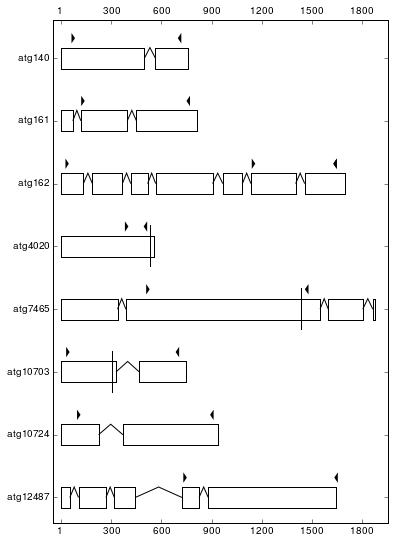

In [88]:
filename = pjoin(STEPS['sequence_extraction'], 'atgs.json')
with open(filename, 'r') as handle:
    atgs = json.load(handle)

fig = plt.figure(figsize=(6, 9))

order = [
    'atg140', 'atg161', 'atg162',
    'atg4020', 'atg7465', 'atg10703',
    'atg10724', 'atg12487'
    ]
new_atgs = [None] * len(order)
for atg in atgs:
    if atg['id'] in order:
        idx = order.index(atg['id'])
        new_atgs[idx] = atg
atgs = new_atgs

max_start = None
max_end = None
max_length = 0

gs = gridspec.GridSpec(len(atgs), 1, hspace=0.)
axes = dict()
first_ax = None
for i, candidate in enumerate(atgs):
    this_candidate = candidate['id']
    if first_ax is not None:
        axes[this_candidate] = fig.add_subplot(
            gs[i],
            sharex=first_ax
            )
    else:
        axes[this_candidate] = fig.add_subplot(gs[i])
        first_ax = axes[this_candidate]
    pm = 50
    seq = genome[candidate['scaffold']]
    start = int(candidate['start']) - pm
    end = int(candidate['end']) + pm
    length = end - start

    if length > max_length:
        max_length = length
        axes[this_candidate].set_xlim(0, roundup(length))
        interval = 300
        axes[this_candidate].set_xticks(
            [pm] + list(
                range(
                    pm + interval - 1,
                    roundup(length), interval
                    )
                )
            )
        axes[this_candidate].set_xticklabels(
            [1] + list(
                range(
                    interval,
                    roundup(length) - pm,
                    interval
                    )
                )
            )

    seq = seq[start:end]
    if candidate['strand'] == -1:
        seq = seq.reverse_complement()

    other_shapes = {
        'variant': Rectangle(
            width=1.,
            y_offset=0.1,
            facecolor='black',
            linewidth=0,
            ),
        'primer': Triangle(
            width=0.25,
            y_offset=0.95,
            facecolor='black',
            linewidth=0,
            )
        }

    feature_patches, text_patches = draw_region(
        seq,
        exon=Rectangle(
            width=0.5,
            y_offset=0.35,
            facecolor='none'
            ),
        intron=OpenTriangle(
            width=0.25,
            y_offset=0.6,
            facecolor='none',
            ),
        intron_threshold=1,
        other_shapes=other_shapes
        )
    for patch in feature_patches:
        axes[this_candidate].add_patch(patch)
    for patch in text_patches:
        axes[this_candidate].add_text(**patch)
    
    axes[this_candidate].set_ylim([0, 1.5])
    
    if i == 0:
        axes[this_candidate].tick_params(
            labeltop='on',
            labelbottom='off'
            )
        axes[this_candidate].xaxis.set_ticks_position('top')
        axes[this_candidate].spines['bottom'].set_visible(False)
    elif i == len(atgs) - 1:
        axes[this_candidate].spines['top'].set_visible(False)
        axes[this_candidate].xaxis.set_ticks_position('bottom')
        axes[this_candidate].tick_params(
            labeltop='off',
            labelbottom='on'
            )
    else:
        axes[this_candidate].tick_params(
            labeltop='off',
            labelbottom='off'
            )
        axes[this_candidate].get_xaxis().set_visible(False)
        axes[this_candidate].spines['top'].set_visible(False)
        axes[this_candidate].spines['bottom'].set_visible(False)

    axes[this_candidate].set_yticks([0.6])
    axes[this_candidate].set_yticklabels([this_candidate])

filename = pjoin(STEPS['drawing_genes'], 'gene_structures')
fig.savefig(filename + '.svg')
fig.savefig(filename + '.pdf')
fig.savefig(filename + '.png', dpi=300)
plt.show()

### Step - `drawing_genes_transcripts`

In [17]:
genome = SeqIO.to_dict(
    SeqIO.parse(GENOME_FILES['MNH120']['fasta'], format="fasta")
    )

primer_gffs = os.listdir(STEPS['primer_gff'])

gffs = GENOME_FILES['MNH120']['gff']
gffs.append(pjoin(STEPS['extract_genes'], 'target_variants.gff3'))
gffs.extend([
    pjoin(STEPS['primer_gff'], g) for g
    in primer_gffs if g.endswith('MNH120.gff3')
    ])

for gff in gffs:
    # Parse GFF annotations.
    genome_with_features = GFF.parse(
        gff,
        base_dict=genome
        )

    """ bcbio-gff codes exons, mRNA etc as subfeatures which is now
    depreciated in biopython, this code fixes that issue. """
    new_genome_with_features = list()
    for scaffold in genome_with_features:
        new_features = list()
        for feature in scaffold.features:
            gene_features = subfeatures(feature)
            new_features.extend(gene_features)
        scaffold.features = new_features
        new_genome_with_features.append(scaffold)

    """ Genome with features doesn't have scaffolds without any gff 
    features. Here I update the existing records in genome with the 
    new ones containing features. """
    genome.update(SeqIO.to_dict(new_genome_with_features))

genome['scaffold_38'].features = fix_atg140(genome)

In [26]:
filename = pjoin(STEPS['sequence_extraction'], 'atgs.json')
with open(filename, 'r') as handle:
    atgs = json.load(handle)

atgs = [a for a in atgs if a['id'] not in {'atg4290'}]

bams = {
    'I17V': "I17V.rnaseq_mapped_MNH120.bam",
    'I31A': "I31A.rnaseq_mapped_MNH120.bam",
    'I5V': "I5V.rnaseq_mapped_MNH120.bam",
    'I65V': "I65V.rnaseq_mapped_MNH120.bam",
    'MNH120': "MNH120.rnaseq_mapped_MNH120.bam",
    'I19A': "I19A.rnaseq_mapped_MNH120.bam",
    'I37A': "I37A.rnaseq_mapped_MNH120.bam",
    'I61A': "I61A.rnaseq_mapped_MNH120.bam",
    'I9A': "I9A.rnaseq_mapped_MNH120.bam"
    }
idxstats_cols = ['seqid', 'length', 'mapped', 'unmapped']

read_counts = dict()
for isolate, bam_file in bams.items():
    filename = pjoin(
        STEPS['drawing_genes_transcripts'],
        os.path.splitext(bam_file)[0] + ".mapped_reads.csv"
        )
    command = [
        "samtools",
        "idxstats",
        pjoin(STEPS['data'], bam_file)
        ]
    with open(filename, 'w') as handle:
        subps = subprocess.Popen(
            command,
            stdout=handle,
            stderr=subprocess.PIPE
            )
        stdout, stderr = subps.communicate()
        #print(stderr.decode())
    
    reads = pd.read_table(filename, names=idxstats_cols)
    read_counts[isolate] = int(reads['mapped'].sum())

filename = pjoin(
    STEPS['drawing_genes_transcripts'],
    'read_counts.json'
    )
with open(filename, 'w') as handle:
    json.dump(read_counts, handle)

pd.DataFrame(
    dict(zip(
        ('isolate', 'count'),
        zip(*read_counts.items())
        ))
    )

,count,isolate
0,42384941,I61A
1,22858718,I37A
2,39897554,I17V
3,92089204,MNH120
4,47833999,I31A
5,53414015,I5V
6,24256795,I19A
7,79489233,I9A
8,30009701,I65V


In [21]:
filename = pjoin(STEPS['sequence_extraction'], 'atgs.json')
with open(filename, 'r') as handle:
    atgs = json.load(handle)

atgs = [a for a in atgs if a['id'] not in {'atg4290'}]

bams = {
    'I17V': "I17V.rnaseq_mapped_MNH120.bam",
    'I31A': "I31A.rnaseq_mapped_MNH120.bam",
    'I5V': "I5V.rnaseq_mapped_MNH120.bam",
    'I65V': "I65V.rnaseq_mapped_MNH120.bam",
    'MNH120': "MNH120.rnaseq_mapped_MNH120.bam",
    'I19A': "I19A.rnaseq_mapped_MNH120.bam",
    'I37A': "I37A.rnaseq_mapped_MNH120.bam",
    'I61A': "I61A.rnaseq_mapped_MNH120.bam",
    'I9A': "I9A.rnaseq_mapped_MNH120.bam"
    }

for isolate, bam_file in bams.items():
    filename = pjoin(
        STEPS['drawing_genes_transcripts'],
        os.path.splitext(bam_file)[0] + ".coverage.csv"
        )
    command = [
        "bedtools", "genomecov",
        "-bga", "-split",
        "-ibam", pjoin(STEPS['data'], bam_file)
        ]
    with open(filename, 'w') as handle:
        subps = subprocess.Popen(
            command,
            stdout=handle,
            stderr=subprocess.PIPE
            )
        stdout, stderr = subps.communicate()
        #print(stderr.decode())
    
    scaffolds = set([a['scaffold'] for a in atgs])
    
    for scaffold in scaffolds:
        filtered_filename = pjoin(
            STEPS['drawing_genes_transcripts'],
            (os.path.splitext(bam_file)[0] +
             ".coverage." + scaffold + ".csv")
            )
        with open(filename, 'r') as in_handle,\
                open(filtered_filename, 'w') as out_handle:
            for line in in_handle:
                row = line.split('\t')
                if row[0] == scaffold:
                    out_handle.write(line)

PermissionError: [Errno 13] Permission denied: '14-drawing_genes_transcripts/I17V.rnaseq_mapped_MNH120.coverage.csv'

In [19]:
filename = pjoin(STEPS['sequence_extraction'], 'atgs.json')
with open(filename, 'r') as handle:
    atgs = json.load(handle)
atgs = [a for a in atgs if a['id'] not in {'atg4290'}]

filename = pjoin(
    STEPS['drawing_genes_transcripts'],
    'read_counts.json'
    )
with open(filename, 'r') as handle:
    read_counts = json.load(handle)

scaffolds = set([a['scaffold'] for a in atgs])
coverages = defaultdict(
    lambda: defaultdict(
        lambda: defaultdict(list)
        )
    )
for scaffold in scaffolds:
    filtered_coverage_files = [
        pjoin(STEPS['drawing_genes_transcripts'], f)
        for f in 
        os.listdir(STEPS['drawing_genes_transcripts']) if
        f.endswith(scaffold + '.csv')
        ]
    for cov_file in filtered_coverage_files:
        isolate = os.path.split(cov_file.split('.')[0])[1]
        total_reads = read_counts[isolate]
        with open(cov_file, 'r') as handle:
            for line in handle:
                line = line.strip().split('\t')
                scaffold, start, end, coverage = line
                if start == end:
                    coverages[scaffold][isolate][
                        'x'].append(int(start))
                    coverages[scaffold][isolate][
                        'y'].append(1e6 * int(coverage) / total_reads)
                else:
                    coverages[scaffold][isolate][
                        'x'].append(int(start))
                    coverages[scaffold][isolate][
                        'y'].append(1e6 * int(coverage) / total_reads)
                    coverages[scaffold][isolate][
                        'x'].append(int(end))
                    coverages[scaffold][isolate][
                        'y'].append(1e6 * int(coverage) / total_reads)

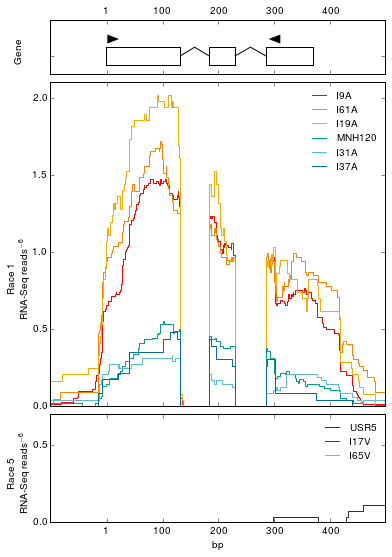

In [35]:
filename = pjoin(STEPS['sequence_extraction'], 'atgs.json')
with open(filename, 'r') as handle:
    atgs = json.load(handle)
for c in atgs:
    if c['id'] == 'atg10719':
        candidate = c
scaffold = candidate['scaffold']
        
seq = genome[scaffold]
pm = 100
start = int(candidate['start']) - pm
length = int(candidate['end']) - int(candidate['start'])

end = start + roundup(length + 150)

x_ticks = list(range(start + 1, end, pm))
x_ticks[0] -= 1
x_tick_labels = list(range(0 - pm, roundup(length + 150), pm))
x_tick_labels[1] = 1
x_tick_labels[0] = ''

fig = plt.figure(figsize=(6, 9))

gs = gridspec.GridSpec(3, 1, height_ratios=[1, 6, 2])
ax_gene = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1], sharex=ax_gene)
ax3 = fig.add_subplot(gs[2], sharex=ax_gene)

other_shapes = {
    'primer': Triangle(
        width=0.25,
        facecolor='black',
        linewidth=0,
        y_offset=0.85,
    )}
feature_patches, text_patches = draw_region(
    seq,
    exon=Rectangle(
        width=0.5,
        y_offset=0.25,
        facecolor='none',
        ),
    intron=OpenTriangle(
        width=0.25,
        y_offset=0.5,
        facecolor='none',
        ),
    other_shapes=other_shapes,
    intron_threshold=1
    )

for patch in feature_patches:
    ax_gene.add_patch(patch)

ax_gene.set_xlim(start, end)
ax_gene.set_ylim([-0., 1.5])
ax_gene.set_yticks([0.5])
ax_gene.tick_params(labeltop='on', labelbottom='off')

ax_gene.set_xticks(x_ticks)
ax_gene.set_xticklabels(x_tick_labels)

ax2.plot(
    coverages[scaffold]['I9A']['x'],
    coverages[scaffold]['I9A']['y'],
    label='I9A',
    color='#FF0000'
    )
ax2.plot(
    coverages[scaffold]['I61A']['x'],
    coverages[scaffold]['I61A']['y'],
    label='I61A',
    color="#F98400"
    )
ax2.plot(
    coverages[scaffold]['I19A']['x'],
    coverages[scaffold]['I19A']['y'],
    label='I19A',
    color="#F2AD00"
    )
ax2.plot(
    coverages[scaffold]['MNH120']['x'],
    coverages[scaffold]['MNH120']['y'],
    label="MNH120",
    color="#00A08A"
    )
ax2.plot(
    coverages[scaffold]['I31A']['x'],
    coverages[scaffold]['I31A']['y'],
    label='I31A',
    color="#5BBCD6"
    )
ax2.plot(
    coverages[scaffold]['I37A']['x'],
    coverages[scaffold]['I37A']['y'],
    label='I37A',
    color="#046C9A"
    )
ax3.plot(
    coverages[scaffold]['I5V']['x'],
    coverages[scaffold]['I5V']['y'],
    label="USR5",
    color='#35274A'
    )
ax3.plot(
    coverages[scaffold]['I17V']['x'],
    coverages[scaffold]['I17V']['y'],
    label='I17V',
    color='#B40F20'
    )
ax3.plot(
    coverages[scaffold]['I65V']['x'],
    coverages[scaffold]['I65V']['y'],
    label="I65V",
    color="#D69C4E"
    )
ax2.set_ylim([0, 2.1])
ax2_legend = ax2.legend(frameon=False, fontsize=10)
ax3.set_ylim([0, 0.7])
ax3.set_yticks([0, .50])
ax3_legend = ax3.legend(frameon=False, fontsize=10)
ax3.set_xlabel('bp')

fig.subplots_adjust(hspace=0.05)
plt.setp([
        a.get_xticklabels() for a in fig.axes[1:-1]
        ], visible=False)
ax_gene.set_yticklabels([''])
fig.text(0.05, 0.85, 'Gene',
         ha='center', va='center',
         rotation='vertical')
fig.text(0.05, 0.5,
         'Race 1\nRNA-Seq reads$^{-6}$',
         ha='center', va='center',
         rotation='vertical')
fig.text(0.05, 0.2,
         'Race 5\nRNA-Seq reads$^{-6}$',
         ha='center', va='center',
         rotation='vertical')

filename = pjoin(
    STEPS['drawing_genes_transcripts'],
    candidate['id'] + '_fullpage_gene_structure'
    )
fig.savefig(filename + '.svg')
fig.savefig(filename + '.pdf')
fig.savefig(filename + '.png', dpi=300)
plt.show()

atg12487


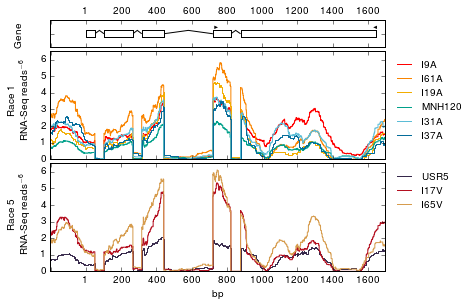

atg161


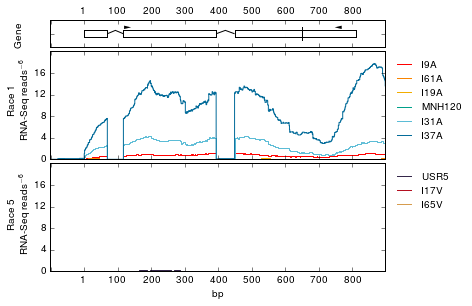

atg162


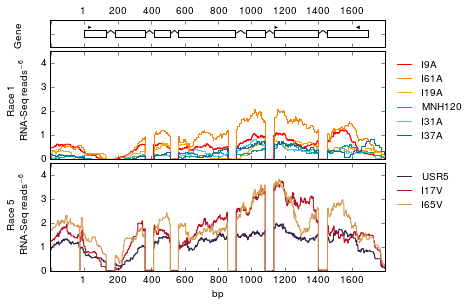

atg4020


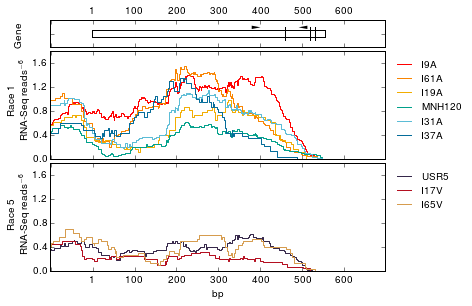

atg140


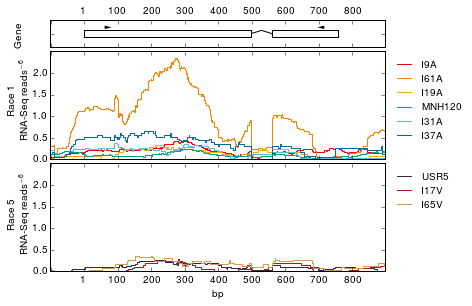

atg7465


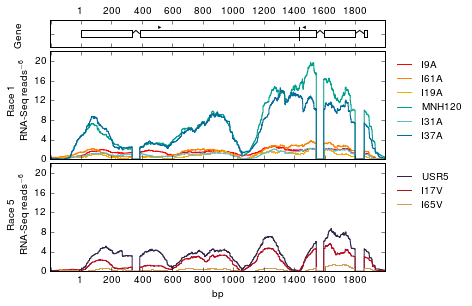

atg10703


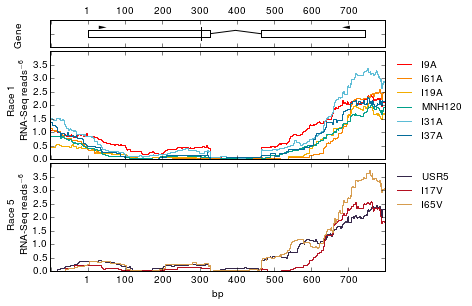

atg10719


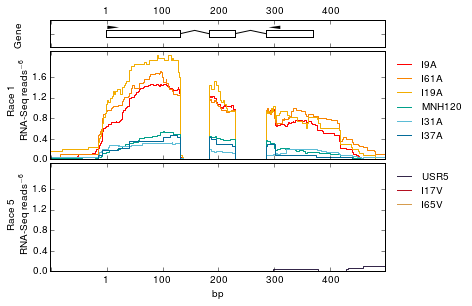

atg10724


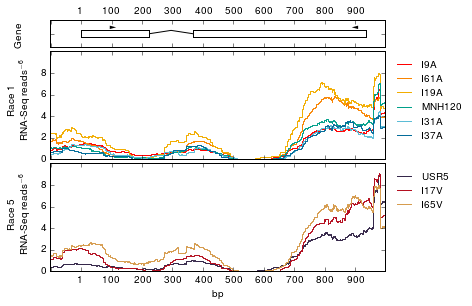

In [36]:
filename = pjoin(STEPS['sequence_extraction'], 'atgs.json')
with open(filename, 'r') as handle:
    atgs = json.load(handle)

atgs = [a for a in atgs if a['id'] not in {'atg4290'}]

ylims = {
    'atg10719': 2.1,
    'atg140': 2.5,
    'atg12487': 6.5,
    'atg161': 20,
    'atg162': 4.5,
    'atg4020': 1.8,
    'atg4290': 10,
    'atg10703': 4,
    'atg10724': 10,
    'atg7465': 22,
    }
yticks = {
    'atg10719': np.arange(0, 1.8, 0.4),
    'atg140': np.arange(0, 2.5, 0.5),
    'atg12487': np.arange(0, 6.5, 1.),
    'atg161': np.arange(0, 20., 4.),
    'atg162': np.arange(0, 4.5, 1.),
    'atg4020': np.arange(0, 1.8, 0.4),
    'atg4290': np.arange(0, 10., 2.),
    'atg10703': np.arange(0, 4., 0.5),
    'atg10724': np.arange(0, 10., 2.),
    'atg7465': np.arange(0, 22., 4.),
    }

for candidate in atgs:
    scaffold = candidate['scaffold']

    seq = genome[scaffold]
    pm = 100
    strand = candidate['strand']
    length = abs(int(candidate['end']) - int(candidate['start']))
    if length > 1000:
        pm = 200

    if strand == -1:
        pm *= strand
        start = int(candidate['end']) - pm
    else:
        pm *= strand
        start = int(candidate['start']) - pm
    
    end_padding = abs(pm) + 50
    end = start + strand * roundup(length + end_padding)

    x_ticks = list(range(start + strand, end, pm))
    #x_ticks[0] -= 1
    x_tick_labels = list(
        range(
            0 - abs(pm),
            roundup(length + end_padding),
            abs(pm)
            )
        )
    x_tick_labels[1] = 1
    x_tick_labels[0] = ''

    fig = plt.figure(figsize=(6, 4.5))

    gs = gridspec.GridSpec(3, 1, height_ratios=[1, 4, 4])
    ax_gene = fig.add_subplot(gs[0])
    ax2 = fig.add_subplot(gs[1], sharex=ax_gene)
    ax3 = fig.add_subplot(gs[2], sharex=ax_gene)
    other_shapes = {
        'primer': Triangle(width=0.25, y_offset=0.85, facecolor='black', linewidth=0),
        'variant': Rectangle(width=1., facecolor='black', linewidth=0),
        }
    feature_patches, text_patches = draw_region(
        seq,
        exon=Rectangle(width=0.5, y_offset=0.25, facecolor='white'),
        intron=OpenTriangle(width=0.25, y_offset=0.5, facecolor='none'),
        other_shapes=other_shapes,
        intron_threshold=1
        )
    
    for patch in feature_patches:
        ax_gene.add_patch(patch)
    for patch in text_patches:
        ax_gene.add_text(**patch)

    ax_gene.set_xlim(start, end)
    ax_gene.set_ylim([-0.5, 1.5])
    ax_gene.set_yticks([0.5])
    ax_gene.set_yticklabels([''])
    ax_gene.tick_params(labeltop='on', labelbottom='off')

    ax_gene.set_xticks(x_ticks)
    ax_gene.set_xticklabels(x_tick_labels)

    ax2.plot(
        coverages[scaffold]['I9A']['x'],
        coverages[scaffold]['I9A']['y'],
        label='I9A',
        color='#FF0000'
        )
    ax2.plot(
        coverages[scaffold]['I61A']['x'],
        coverages[scaffold]['I61A']['y'],
        label='I61A',
        color="#F98400"
        )
    ax2.plot(
        coverages[scaffold]['I19A']['x'],
        coverages[scaffold]['I19A']['y'],
        label='I19A',
        color="#F2AD00"
        )
    ax2.plot(
        coverages[scaffold]['MNH120']['x'],
        coverages[scaffold]['MNH120']['y'],
        label="MNH120",
        color="#00A08A"
        )
    ax2.plot(
        coverages[scaffold]['I31A']['x'],
        coverages[scaffold]['I31A']['y'],
        label='I31A',
        color="#5BBCD6"
        )
    ax2.plot(
        coverages[scaffold]['I37A']['x'],
        coverages[scaffold]['I37A']['y'],
        label='I37A',
        color="#046C9A"
        )

    ax2_legend = ax2.legend(
        frameon=False,
        fontsize=10,
        bbox_to_anchor=(1., 1.),
        loc=2
        )

    ax3.plot(
        coverages[scaffold]['I5V']['x'],
        coverages[scaffold]['I5V']['y'],
        label="USR5",
        color='#35274A'
        )
    ax3.plot(
        coverages[scaffold]['I17V']['x'],
        coverages[scaffold]['I17V']['y'],
        label='I17V',
        color='#B40F20'
        )
    ax3.plot(
        coverages[scaffold]['I65V']['x'],
        coverages[scaffold]['I65V']['y'],
        label="I65V",
        color="#D69C4E"
        )

    ax3_legend = ax3.legend(
        frameon=False,
        fontsize=10,
        bbox_to_anchor=(1., 1.),
        loc=2
        )

    ax2.set_ylim(0, ylims[candidate['id']])
    ax3.set_ylim(0, ylims[candidate['id']])
    ax2.set_yticks(yticks[candidate['id']])
    ax3.set_yticks(yticks[candidate['id']])
    ax3.set_xlabel('bp')
    fig.subplots_adjust(hspace=0.05)
    plt.setp([
        a.get_xticklabels() for a in \
        fig.axes[1:-1]
        ], visible=False)

    fig.text(0.05, 0.85, 'Gene',
             ha='center', va='center',
             rotation='vertical')
    fig.text(0.05, 0.65,
             'Race 1\nRNA-Seq reads$^{-6}$',
             ha='center', va='center',
             rotation='vertical')
    fig.text(0.05, 0.3,
             'Race 5\nRNA-Seq reads$^{-6}$',
             ha='center', va='center',
             rotation='vertical')

    print(candidate['id'])
    filename = pjoin(
        STEPS['drawing_genes_transcripts'],
        candidate['id'] + '_gene_structure'
        )
    fig.savefig(filename + '.svg')
    fig.savefig(filename + '.pdf')
    fig.savefig(filename + '.png', dpi=300)
    plt.show()

122743 125943


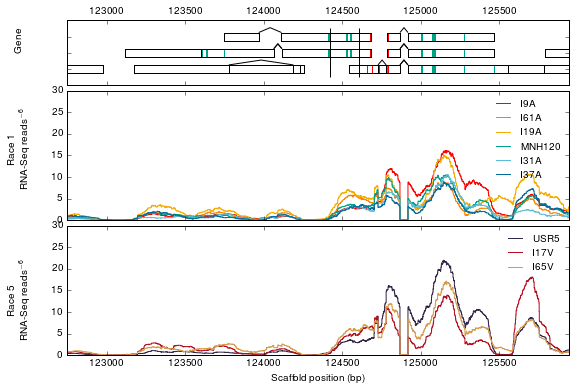

In [37]:
filename = pjoin(STEPS['sequence_extraction'], 'atgs.json')
with open(filename, 'r') as handle:
    atgs = json.load(handle)
for c in atgs:
    if c['id'] == 'atg10724':
        candidate = c

with open(pjoin(STEPS['data'], 'VHA1.PASA.gff3'), 'r') as handle:
    pasa_features = GFF.parse(handle)

    """ bcbio-gff codes exons, mRNA etc as subfeatures which is now
    depreciated in biopython, this code fixes that issue. """
    new_pasa_features = list()
    for scaffold in pasa_features:
        new_features = list()
        for feature in scaffold.features:
            try:
                gene_features = subfeatures(feature)
            except:
                print(feature)
                raise
            new_features.extend(gene_features)
        scaffold.features = new_features
        new_pasa_features.append(scaffold)
    pasa_features = SeqIO.to_dict(new_pasa_features)

with open(pjoin(STEPS['data'], 'transcripts.gtf'), 'r') as handle:
    cufflinks_features = GFF.parse(handle)

    """ bcbio-gff codes exons, mRNA etc as subfeatures which is now
    depreciated in biopython, this code fixes that issue. """
    new_cuff_features = list()
    for scaffold in cufflinks_features:
        new_features = list()
        for feature in scaffold.features:
            try:
                gene_features = subfeatures(feature)
            except:
                print(feature)
                raise
            new_features.extend(gene_features)
        scaffold.features = new_features
        new_cuff_features.append(scaffold)
    cufflinks_features = SeqIO.to_dict(new_cuff_features)
    
scaffold = candidate['scaffold']

seq = genome[scaffold]
pm = 1000
start = int(candidate['start']) - pm
length = int(candidate['end']) - int(candidate['start'])

end = start + roundup(length + 2200)

x_ticks = list(range(start + 1, end, pm))
x_ticks[0] -= 1
x_tick_labels = list(range(0 - pm, roundup(length + 150), pm))
x_tick_labels[1] = 1
x_tick_labels[0] = ''

fig = plt.figure(figsize=(9, 6))

gs = gridspec.GridSpec(3, 1, height_ratios=[1, 2, 2])
ax_gene = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1], sharex=ax_gene)
ax3 = fig.add_subplot(gs[2], sharex=ax_gene)

# add start and stop positions
start_codon = Rectangle(width=0.5, y_offset=0.25, facecolor=cat_colours[1], ec=cat_colours[1])
stop_codon = Rectangle(width=0.5, y_offset=0.25, facecolor=cat_colours[0], ec=cat_colours[0])
augustus_starts = [
    (123744, 123746), (124411, 124413), (124414, 124416),
    (124525, 125527), (124549, 124551), # (124741, 124743)
    (125466, 125468), (125274, 125276), (125085, 125087),
    (125073, 125075), (125004, 125006), 
    ]
augustus_stops = [
    (124678, 124680), (124788, 124790),
    ]

pasa_starts = [
    (123603, 123605), (123633, 123635), (123744, 123746),
    (124411, 124413), (124414, 124416), # (124741, 124743),
    (124525, 125527), (124549, 124551), (125466, 125468),
    (125274, 125276), (125085, 125087), (125073, 125075),
    (125004, 125006),
    ]
pasa_stops = [
    (124678, 124680), (124788, 124790),
    ]

cuff_starts = [
    (125466, 125468), (125274, 125276), (125085, 125087),
    (125073, 125075), (125004, 125006), (124779, 124781),
    ]
cuff_stops = [
    (124788, 124790), (124776, 124778), (124728, 124730),
    (124731, 124733), (124686, 124688), (124656, 124658),
    ]

codons = list()
for s, e in augustus_starts:
    p = Path(*start_codon(s, 2, 3))
    codons.append(
        patches.PathPatch(
            p,
            **start_codon.properties
            )
        )
for s, e in pasa_starts:
    p = Path(*start_codon(s, 1, 3))
    codons.append(
        patches.PathPatch(
            p,
            **start_codon.properties
            )
        )
for s, e in cuff_starts:
    p = Path(*start_codon(s, 0, 3))
    codons.append(
        patches.PathPatch(
            p,
            **start_codon.properties
            )
        )
for s, e in augustus_stops:
    p = Path(*stop_codon(s, 2, 3))
    codons.append(
        patches.PathPatch(
            p,
            **stop_codon.properties
            )
        )
for s, e in pasa_stops:
    p = Path(*stop_codon(s, 1, 3))
    codons.append(
        patches.PathPatch(
            p,
            **stop_codon.properties
            )
        )
for s, e in cuff_stops:
    p = Path(*stop_codon(s, 0, 3))
    codons.append(
        patches.PathPatch(
            p,
            **stop_codon.properties
            )
        )
    
for codon in codons:
    ax_gene.add_patch(codon)

feature_patches, text_patches = draw_region(
    pasa_features[scaffold],
    exon=Rectangle(width=0.5, y_offset=1.25, facecolor='none'),
    intron=OpenTriangle(width=0.3, y_offset=1.75, facecolor='none'),
    intron_threshold=1
    )
for patch in feature_patches:
    ax_gene.add_patch(patch)
for patch in text_patches:
    ax_gene.add_text(**patch)

feature_patches, text_patches = draw_region(
    cufflinks_features[scaffold],
    exon=Rectangle(width=0.5, y_offset=0.25, facecolor='none'),
    intron=OpenTriangle(width=0.3, y_offset=0.75, facecolor='none'),
    intron_threshold=1
    )
for patch in feature_patches:
    ax_gene.add_patch(patch)
for patch in text_patches:
    ax_gene.add_text(**patch)

other_shapes = {'variant': Rectangle(width=3., y_offset=0.)}
feature_patches, text_patches = draw_region(
    seq,
    exon=Rectangle(width=0.5, y_offset=2.25, facecolor='none'),
    intron=OpenTriangle(width=0.3, y_offset=2.75, facecolor='none'),
    other_shapes=other_shapes,
    intron_threshold=1
    )
for patch in feature_patches:
    ax_gene.add_patch(patch)
for patch in text_patches:
    ax_gene.add_text(**patch)


print(start, end)
ax_gene.set_xlim(start, end)
ax_gene.set_ylim([-0.5, 3.5])
ax_gene.set_yticks([0.5, 1.5, 2.5])
ax_gene.set_yticklabels(['cufflinks', 'pasa', 'augustus'])
ax_gene.tick_params(labeltop='on', labelbottom='off')

#ax_gene.set_xticks(x_ticks)
#ax_gene.set_xticklabels(x_tick_labels)

ax2.plot(
    coverages[scaffold]['I9A']['x'],
    coverages[scaffold]['I9A']['y'],
    label='I9A',
    color='#FF0000'
    )
ax2.plot(
    coverages[scaffold]['I61A']['x'],
    coverages[scaffold]['I61A']['y'],
    label='I61A',
    color="#F98400"
    )
ax2.plot(
    coverages[scaffold]['I19A']['x'],
    coverages[scaffold]['I19A']['y'],
    label='I19A',
    color="#F2AD00"
    )
ax2.plot(
    coverages[scaffold]['MNH120']['x'],
    coverages[scaffold]['MNH120']['y'],
    label="MNH120",
    color="#00A08A"
    )
ax2.plot(
    coverages[scaffold]['I31A']['x'],
    coverages[scaffold]['I31A']['y'],
    label='I31A',
    color="#5BBCD6"
    )
ax2.plot(
    coverages[scaffold]['I37A']['x'],
    coverages[scaffold]['I37A']['y'],
    label='I37A',
    color="#046C9A"
    )
ax3.plot(
    coverages[scaffold]['I5V']['x'],
    coverages[scaffold]['I5V']['y'],
    label="USR5",
    color='#35274A'
    )
ax3.plot(
    coverages[scaffold]['I17V']['x'],
    coverages[scaffold]['I17V']['y'],
    label='I17V',
    color='#B40F20'
    )
ax3.plot(
    coverages[scaffold]['I65V']['x'],
    coverages[scaffold]['I65V']['y'],
    label="I65V",
    color="#D69C4E"
    )
ax2.set_ylim([0, 30])
ax2_legend = ax2.legend(frameon=False, fontsize=10)
ax3.set_ylim([0, 30])
ax3.set_xlabel('Scaffold position (bp)')
#ax3.set_yticks([0, .20, .40])
ax3_legend = ax3.legend(frameon=False, fontsize=10)

fig.subplots_adjust(hspace=0.05)
plt.setp([
    a.get_xticklabels() for a in \
    fig.axes[1:-1]
    ], visible=False)
ax_gene.set_yticklabels([''])
fig.text(0.05, 0.85, 'Gene',
         ha='center', va='center',
         rotation='vertical')
fig.text(0.05, 0.6,
         'Race 1\nRNA-Seq reads$^{-6}$',
         ha='center', va='center',
         rotation='vertical')
fig.text(0.05, 0.25,
         'Race 5\nRNA-Seq reads$^{-6}$',
         ha='center', va='center',
         rotation='vertical')

filename = pjoin(
    STEPS['drawing_genes_transcripts'],
    candidate['id'] + '_altmodels_gene_structure'
    )
fig.savefig(filename + '.svg')
fig.savefig(filename + '.pdf')
fig.savefig(filename + '.png', dpi=300)
plt.show()

### Step - `drawing_alignments`

In [74]:
def pos_formatter(start, end):
    return "{}..{}".format(str(start + 1), str(end))

In [75]:
genome = SeqIO.to_dict(
    SeqIO.parse(
        GENOME_FILES['MNH120']['fasta'],
        format="fasta"
        )
    )

primer_gffs = os.listdir(STEPS['primer_gff'])

gffs = GENOME_FILES['MNH120']['gff']
gffs.append(
    pjoin(STEPS['extract_genes'], 'target_variants.gff3')
    )
gffs.extend([
    pjoin(STEPS['primer_gff'], g) for g in primer_gffs if \
    g.endswith('MNH120.gff3')
    ])

for gff in gffs:
    # Parse GFF annotations.
    genome_with_features = GFF.parse(
        gff,
        base_dict=genome
        )

    """ bcbio-gff codes exons, mRNA etc as subfeatures which is now
    depreciated in biopython, this code fixes that issue. """
    new_genome_with_features = list()
    for scaffold in genome_with_features:
        new_features = list()
        for feature in scaffold.features:
            gene_features = subfeatures(feature)
            new_features.extend(gene_features)
        scaffold.features = new_features
        new_genome_with_features.append(scaffold)

    """ Genome with features doesn't have scaffolds without any gff 
    features. Here I update the existing records in genome with the 
    new ones containing features. """
    genome.update(SeqIO.to_dict(new_genome_with_features))

genome['scaffold_38'].features = fix_atg140(genome)

In [76]:
template = r'''
%\documentclass[tikz, crop=true]{{standalone}}
\documentclass{{article}}
\usepackage{{texshade}}

\begin{{document}}

\begin{{texshade}}{{{filename}}}
\setfamily{{names}}{{sffamily}}
\setfamily{{numbering}}{{sffamily}}
\setfamily{{legend}}{{sffamily}}
\nameseq{{I5V}}{{USR5}}

\definecolor{{DarkCyan}}{{cmyk}}{{1,0,0.14,0.37}}

\shadingmode{{diverse}}
%\shadingcolors{{grays}}

%\fingerprint{{{length}}}
%\gapchar{{rule}}
{exons}
{introns}

{variants}
{primers}
%\showlegend
\showcaption{{}}
\end{{texshade}}
\end{{document}}
'''

fingerprint_template = r'''
\documentclass[tikz, crop=true]{{standalone}}
%\documentclass{{article}}
\usepackage{{texshade}}
\renewcommand{{\sfdefault}}{{phv}}
\renewcommand{{\rmdefault}}{{ptm}}
\usepackage{{inconsolata}}

\begin{{document}}

\begin{{texshade}}{{{filename}}}
\setfamily{{names}}{{sffamily}}
\setfamily{{numbering}}{{sffamily}}
\setfamily{{legend}}{{sffamily}}
\nameseq{{I5V}}{{USR5}}

\definecolor{{DarkCyan}}{{cmyk}}{{1,0,0.14,0.37}}

%\shadingmode{{diverse}}
\shadingcolors{{grays}}

\fingerprint{{{length}}}
\gapchar{{rule}}
{exons}
{introns}

{variants}
{primers}
\showlegend
%\showcaption{{}}
\end{{texshade}}
\end{{document}}
'''


primer_template_f = (
    r'\feature{{ttop}}{{MNH120}}'
    '{{{pos}}}{{-->}}{{Fwd}}'
    )
primer_template_r = (
    r'\feature{{ttop}}{{MNH120}}'
    '{{{pos}}}{{<--}}{{Rev}}'
    )
variant_template = (
    r'\frameblock{{MNH120}}{{{pos}}}'
    '{{Black[1pt]}}'
    )
exon_template = (
    r'\feature{{top}}{{MNH120}}'
    '{{{pos}}}{{box[DarkCyan]}}{{}}'
    )
intron_template = (
    r'\feature{{top}}{{MNH120}}'
    '{{{pos}}}{{---}}{{}}'
    )

In [77]:
with open(
        pjoin(
            STEPS['extract_genes'],
            'extracted_regions.json'
            ),
        'r') as handle:
    extracted_regions = json.load(handle)

filename = pjoin(
    STEPS['align_regions'],
    'aligned_regions_files.json'
    )
with open(filename, 'r') as handle:
    aligned_regions_files = json.load(handle)

for candidate, alignment_file in aligned_regions_files.items():
    tex_args = dict()
    filename = os.path.split(alignment_file)[1]
    alignment = AlignIO.read(
        alignment_file,
        format='fasta',
        alphabet=DNAAlphabet()
        )
    
    order = [
        'MNH120', 'B04', 
        'I5V', 'I9A',
        'I17V', 'I19A',
        'I31A', 'I37A',
        'I61A', 'I65V',
        ]
    new_order = [0] * len(alignment)
    for sequence in alignment:
        sequence.id = sequence.id.split('-')[0]
        new_order[order.index(sequence.id)] = sequence
    alignment._records = new_order
    
    new_filename = os.path.splitext(filename)[0] + '.msf'
    AlignIO.write(
        alignment,
        pjoin(STEPS['drawing_alignments'], new_filename),
        format='clustal'
        )

    tex_args['filename'] = new_filename
    tex_args['length'] = len(alignment[0])
    # Find CDS
    region = extracted_regions[candidate]['MNH120']
    scaffold = region['scaffold']
    start = region['start']
    end = region['end']
    strand = region['strand']
    sequence = genome[scaffold][start:end]
    if strand == -1:
        sequence = sequence.reverse_complement()
    
    features = sequence.features
    exons = [
        f for f in features if \
        f.type == 'CDS'
        ][0].location.parts

    exons = [(f.start, f.end) for f in exons]
    exons.sort(key=lambda f: min(f[0], f[1]))
    introns = list()
    last = -1
    for exon in exons:
        if last < 0:
            last = exon[1]
        else:
            introns.append((last, exon[0]))
            last = exon[1]
    
    tex_args['exons'] = "\n".join([
            exon_template.format(
                pos=pos_formatter(*exon)
                ) for exon in exons
        ])
    tex_args['introns'] = "\n".join([
        intron_template.format(
            pos=pos_formatter(*intron)
            ) for intron in introns
        ])

    # Find target
    variants = [
        f.location for f in features if \
        f.type == 'variant'
        ]
    variants = [
        pos_formatter(
            min(f.start, f.end) + 1,
            max(f.start, f.end) + 1
            ) for f in variants
        ]
    if len(variants) > 0:
        tex_args['variants'] = '\n'.join(
            [variant_template.format(pos=','.join(variants))]
            )
    else:
        tex_args['variants'] = ''

    # Find primers
    fwd_primers = [
        f.location for f in features if \
        (f.type == 'primer' and f.strand == 1)
        ]
    fwd_primers = [
        primer_template_f.format(
            pos=pos_formatter(f.start, f.end + 1)
            )
        for f in fwd_primers
        ]
    rev_primers = [
        f.location for f in features if \
        (f.type == 'primer' and f.strand == -1)
        ]
    rev_primers = [
        primer_template_r.format(
            pos=pos_formatter(f.start, f.end + 1)
            ) 
        for f in rev_primers
        ]

    tex_args['primers'] = "\n".join(fwd_primers + rev_primers)
    
    # Write the tex file to disk
    filename = pjoin(
        STEPS['drawing_alignments'],
        'aligned_region_' + candidate + '.tex'
        )
    with open(filename, 'w') as handle:
        handle.write(template.format(**tex_args))

    # Write the tex file to disk
    filename = pjoin(
        STEPS['drawing_alignments'],
        'fingerprint_region_' + candidate + '.tex'
        )
    with open(filename, 'w') as handle:
        handle.write(fingerprint_template.format(**tex_args))

pdf_descriptor = '''\
'''

for file_ in os.listdir(STEPS['drawing_alignments']):
    if os.path.splitext(file_)[-1] != '.tex':
        continue
    filename = pjoin(STEPS['drawing_alignments'], file_)
    command = [
        'latexmk',
        '-cd',
        '-pdf',
        '-interaction=nonstopmode',
        filename
        ]
    subps = subprocess.Popen(
        command,
        stdout=subprocess.PIPE,
        stderr=subprocess.PIPE
        )
    stdout, stderr = subps.communicate()
    #print(stdout, stderr)

    # Cleanup intermediate files
    subps = subprocess.Popen(
        ['latexmk', '-c'],
        cwd=STEPS['drawing_alignments'],
        stdout=subprocess.PIPE,
        stderr=subprocess.PIPE
        )